In [1]:
%matplotlib inline

from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

# Data Acquisition

For this assignment, you must download the dataset from [here](http://ec2-52-41-153-66.us-west-2.compute.amazonaws.com:8000/data.zip) and extract it into `data/`. The dataset contains approximately 80K training images and 100 validation images, with multiple captions/tags for each image. For this assignment, we are only concerned with the tags and ignore the captions.

Ideally, unless you happen to have **much faster** internet than I do, you will want to download the data directly to your server: `wget http://ec2-52-41-153-66.us-west-2.compute.amazonaws.com:8000/data.zip`.

For question two on the assignment, the dataset also contains a JSON file that maps from the ImageNet labels to the category names. 

Following the data downloading and unzipping, the code below loads in the data into memory accordingly.

In [2]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Scale(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var.cuda(device_id=0)

load_image('data/train2014/COCO_train2014_000000000009.jpg')

Variable containing:
( 0 , 0 ,.,.) = 
  0.0039  0.0078  0.0039  ...   0.0471  0.0471  0.0314
  0.0039  0.0039  0.0039  ...   0.0353  0.0353  0.0392
  0.0039  0.0039  0.0039  ...   0.0392  0.0392  0.0510
           ...             ⋱             ...          
  0.7137  0.7294  0.7137  ...   0.1686  0.1843  0.1686
  0.7059  0.6902  0.6863  ...   0.1765  0.1804  0.2039
  0.6784  0.6667  0.6706  ...   0.1922  0.2157  0.2275

( 0 , 1 ,.,.) = 
  0.1490  0.1490  0.1412  ...   0.0039  0.0039  0.0039
  0.1451  0.1412  0.1373  ...   0.0039  0.0039  0.0039
  0.1412  0.1373  0.1373  ...   0.0039  0.0039  0.0039
           ...             ⋱             ...          
  0.4392  0.4667  0.4549  ...   0.2588  0.2745  0.2863
  0.4353  0.4235  0.4196  ...   0.2745  0.2980  0.3137
  0.4118  0.4000  0.4000  ...   0.3020  0.3176  0.3020

( 0 , 2 ,.,.) = 
  0.5294  0.5294  0.5294  ...   0.1451  0.1412  0.1333
  0.5255  0.5333  0.5373  ...   0.1725  0.1451  0.1412
  0.5373  0.5490  0.5451  ...   0.2314  0.1843

In [3]:
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open('data/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 100K training images.
mscoco_train = json.load(open('data/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open('data/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore 
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore 
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

In [3]:
#hs just testing out stuff
"""
print(mscoco_val['categories'][54])
print(mscoco_val['categories'])
mscoco_val['annotations']
#413
print(mscoco_val['images'])
category_to_idx[60]
category_to_name[60]
category_idx_to_name[54]
imagenet_categories[613]
imagenet_categories[613]
"""

"\nprint(mscoco_val['categories'][54])\nprint(mscoco_val['categories'])\nmscoco_val['annotations']\n#413\nprint(mscoco_val['images'])\ncategory_to_idx[60]\ncategory_to_name[60]\ncategory_idx_to_name[54]\nimagenet_categories[613]\nimagenet_categories[613]\n"

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/val2014/COCO_val2014_000000391895.jpg`. The image is shown below.

![image](data/val2014/COCO_val2014_000000391895.jpg)

The following code determines the category labels for this image.

In [121]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# 1. Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

In [122]:
vgg_model = models.vgg16(pretrained=True).cuda()
vgg_model.eval()

# Let's see what the model looks like.
vgg_model

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

# 2. Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

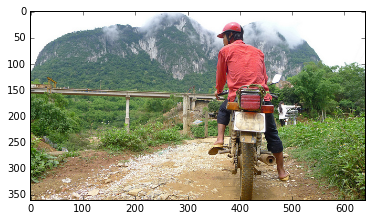

Actual Labels:
0. person
1. bicycle
2. motorcycle


Predicted Labels:
assault rifle, assault gun    **prob:  0.15978242456912994
stretcher    **prob:  0.11211048811674118
rifle    **prob:  0.08014337718486786
military uniform    **prob:  0.05696123465895653
jeep, landrover    **prob:  0.04559891298413277


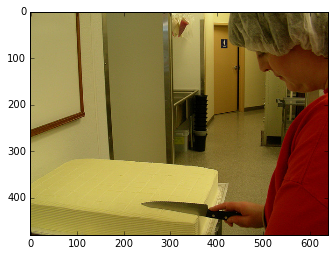

Actual Labels:
0. sink
1. person
2. cake
3. knife


Predicted Labels:
mosquito net    **prob:  0.2567022740840912
toilet tissue, toilet paper, bathroom tissue    **prob:  0.08372802287340164
wardrobe, closet, press    **prob:  0.08116978406906128
washbasin, handbasin, washbowl, lavabo, wash-hand basin    **prob:  0.04646630957722664
medicine chest, medicine cabinet    **prob:  0.037629418075084686


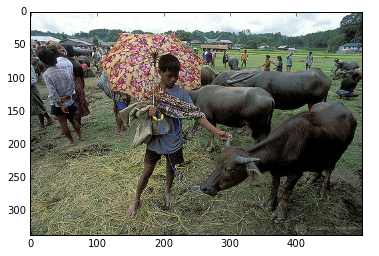

Actual Labels:
0. person
1. umbrella
2. cow


Predicted Labels:
Arabian camel, dromedary, Camelus dromedarius    **prob:  0.16984766721725464
sandbar, sand bar    **prob:  0.08143867552280426
Italian greyhound    **prob:  0.07307641953229904
Weimaraner    **prob:  0.0661785900592804
swimming trunks, bathing trunks    **prob:  0.03160249441862106


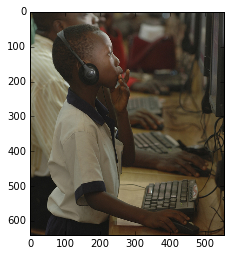

Actual Labels:
0. tv
1. person
2. mouse
3. keyboard


Predicted Labels:
plastic bag    **prob:  0.12806937098503113
lab coat, laboratory coat    **prob:  0.09797217696905136
toilet tissue, toilet paper, bathroom tissue    **prob:  0.06251274049282074
bonnet, poke bonnet    **prob:  0.059056587517261505
gasmask, respirator, gas helmet    **prob:  0.05744166299700737


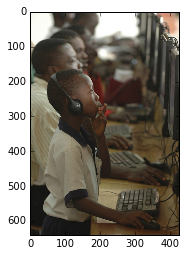

Actual Labels:
0. tv
1. person
2. mouse
3. keyboard


Predicted Labels:
plastic bag    **prob:  0.07708367705345154
groom, bridegroom    **prob:  0.073569655418396
gasmask, respirator, gas helmet    **prob:  0.0723777562379837
toilet tissue, toilet paper, bathroom tissue    **prob:  0.06662330031394958
mosquito net    **prob:  0.05071505531668663


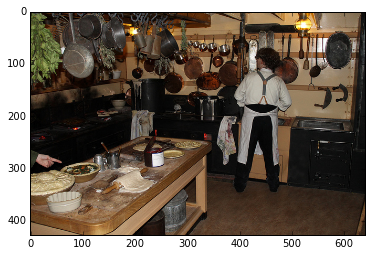

Actual Labels:
0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot


Predicted Labels:
dining table, board    **prob:  0.3610764443874359
grand piano, grand    **prob:  0.19368433952331543
mosquito net    **prob:  0.10433460772037506
restaurant, eating house, eating place, eatery    **prob:  0.03340998664498329
desk    **prob:  0.01999104768037796


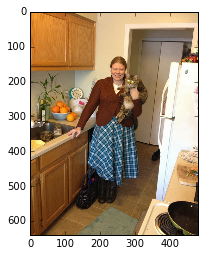

Actual Labels:
0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag


Predicted Labels:
bath towel    **prob:  0.08990365266799927
dishwasher, dish washer, dishwashing machine    **prob:  0.08958449959754944
shower cap    **prob:  0.05552596226334572
bassinet    **prob:  0.04780018329620361
hand blower, blow dryer, blow drier, hair dryer, hair drier    **prob:  0.04668572172522545


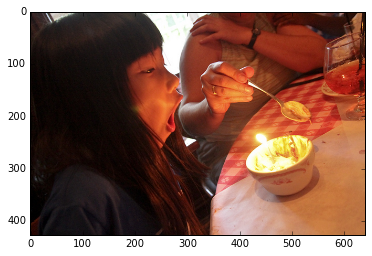

Actual Labels:
0. dining table
1. person
2. spoon
3. bowl
4. wine glass


Predicted Labels:
Petri dish    **prob:  0.2044173777103424
bubble    **prob:  0.07034048438072205
groom, bridegroom    **prob:  0.03852953389286995
tub, vat    **prob:  0.03593295067548752
candle, taper, wax light    **prob:  0.03349293768405914


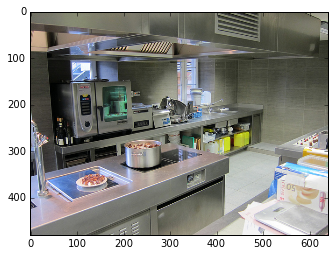

Actual Labels:
0. sink
1. bowl
2. bottle
3. oven


Predicted Labels:
photocopier    **prob:  0.2724073827266693
refrigerator, icebox    **prob:  0.19901126623153687
medicine chest, medicine cabinet    **prob:  0.08543196320533752
microwave, microwave oven    **prob:  0.07895394414663315
dishwasher, dish washer, dishwashing machine    **prob:  0.06784959882497787


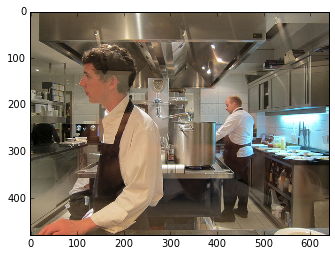

Actual Labels:
0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack


Predicted Labels:
lab coat, laboratory coat    **prob:  0.480535089969635
mosquito net    **prob:  0.20499758422374725
hoopskirt, crinoline    **prob:  0.027210328727960587
pajama, pyjama, pj's, jammies    **prob:  0.024718964472413063
beaker    **prob:  0.02309335209429264


In [123]:
softmax = nn.Softmax()
for image_id in val_ids[:10]:
    # Display the image.
    # -- Your code goes here --
    image = Image.open(val_id_to_file[image_id]).convert('RGB')
    plt.imshow(image)
    plt.figure(image_id)
    plt.show()
    

    # Print all of the category labels for this image.
    # -- Your code goes here --
    print("Actual Labels:")
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))
        
    print("\n")
  
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])

    # Run the image through the model and softmax.
    label_likelihoods = softmax(vgg_model(img)).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)
        
    
    # Iterate and print out the predictions.
    # -- Your code goes here --
    print("Predicted Labels:")
    for p, i in zip(probs,indices):
        temp = i.cpu().data
        temp = temp.numpy()
        tempP = p.cpu().data
        tempP = tempP.numpy()
        print(imagenet_categories[int(temp)], "   **prob: ", float(tempP))
  

# 3. Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [124]:
# Remove the final layer of the classifier, and indicate to PyTorch that the model is being used for inference
# rather than training (most importantly, this disables dropout).
    
# -- Your code goes here --
"""
HS solution: models in PyTorch are usually two seperate networks a feature extraction 
and a classification, each stored in a list. The classification in vgg_model.features and
classification in vgg_model.classifier. 

These DL models in PyTorch all extend the nn.Modules class, their network fields all extend the
nn.Sequential class. So you can create your modified
version by creating a nn.Seqential class from their data. (cast to a list). You can then override
each part that you want.
"""
#modified_vgg_model = nn.Sequential(*list(vgg_model.features.children())[:-1]) # just the features - last 1 (up to last Relu in features (29))
#modified_vgg_model = nn.Sequential(*list(vgg_model.classifier.children())[:-2]) # just the classifier - last2 (without last linear and last dro out)

"""fails in prediction
modified_vgg_model = nn.Sequential(*list(vgg_model.features.children()))
modified_vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:])
modified_vgg_model
 
Below creates a whole new class, which extends nn.Module, has a model as fields, and overrides
the forward method. 
"""

class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.modified_vgg_model = models.vgg16(pretrained=True).cuda()
        self.modified_vgg_model.classifier = nn.Sequential(
            *(self.modified_vgg_model.classifier[i] for i in range(5)))

    def forward(self, images):
        return self.modified_vgg_model(images)



modified_vgg_model = MyModel()
modified_vgg_model.eval()

# Let's see what the model looks like.
modified_vgg_model


#hs Unit Test:
'''
image_id = val_ids[1]

# Display the image.
image = Image.open(val_id_to_file[image_id]).convert('RGB')
plt.imshow(image)
plt.figure(image_id)
plt.show()
    
# Load/preprocess the image.
img = load_image(val_id_to_file[image_id])
out_features = modified_vgg_model(img).squeeze()
 
print(len(out_features))
'''

"\nimage_id = val_ids[1]\n\n# Display the image.\nimage = Image.open(val_id_to_file[image_id]).convert('RGB')\nplt.imshow(image)\nplt.figure(image_id)\nplt.show()\n    \n# Load/preprocess the image.\nimg = load_image(val_id_to_file[image_id])\nout_features = modified_vgg_model(img).squeeze()\n \nprint(len(out_features))\n"

In [ ]:
# First we vectorize all of the features of training images and write the results to a file.

# -- Your code goes here --
training_vectors = []
for image_id in train_ids[:]:
    img = load_image(train_id_to_file[image_id])
    
    '''
    print("\nTrIm: ", image_id)
    image = Image.open(train_id_to_file[image_id]).convert('RGB')
    plt.imshow(image)
    plt.figure(image_id)
    plt.show()
    '''
    
    out_features = modified_vgg_model(img).squeeze()
    
    temp = out_features.cpu().data
    temp = temp.numpy()
    training_vectors.append(temp)

print(len(training_vectors))
np.save(open('outputs/training_vectors', 'wb+'), training_vectors)

In [110]:
# Next we vectorize all of the features of validation images and write the results to a file.
    
# -- Your code goes here --
validation_vectors = []
for image_id in val_ids[:]:
    img = load_image(val_id_to_file[image_id])
    
    '''
    print("\nValIm: ", image_id)
    image = Image.open(val_id_to_file[image_id]).convert('RGB')
    plt.imshow(image)
    plt.figure(image_id)
    plt.show()
    '''
    
    out_features = modified_vgg_model(img).squeeze()
    
    temp = out_features.cpu().data
    temp = temp.numpy()
    validation_vectors.append(temp)
    
print(len(validation_vectors))
np.save(open('outputs/validation_vectors', 'wb+'), validation_vectors)

#this works too, might be even better
#np.save(open('outputs/validation_vectors', 'wb+'), np.array(validation_vectors))

100


# 4. Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

Valdation ImageId:  391895


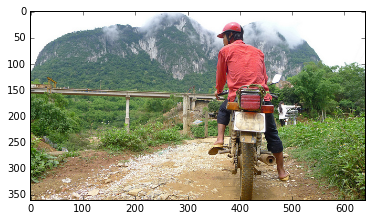


 NN in TrainingSet ImageId:  449158 ,  Index:  42502


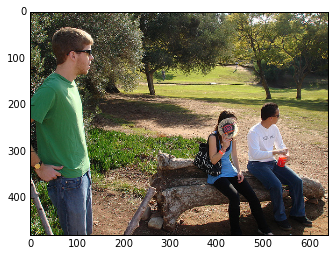

Valdation ImageId:  522418


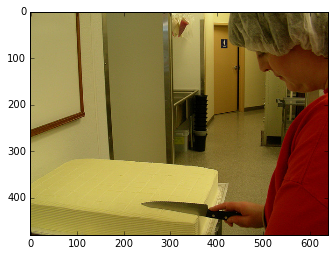


 NN in TrainingSet ImageId:  518189 ,  Index:  79957


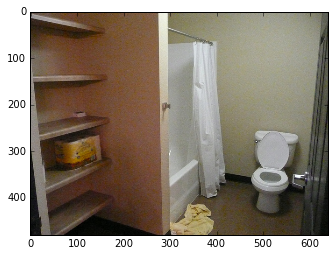

Valdation ImageId:  184613


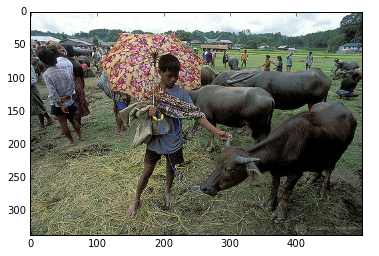


 NN in TrainingSet ImageId:  85035 ,  Index:  39447


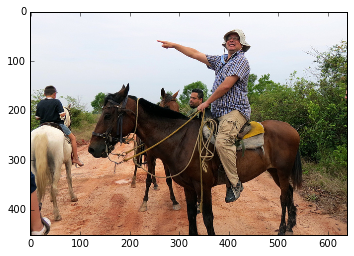

Valdation ImageId:  318219


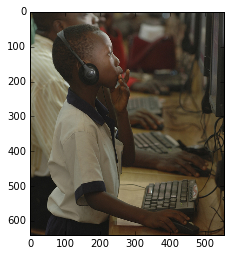


 NN in TrainingSet ImageId:  14769 ,  Index:  9657


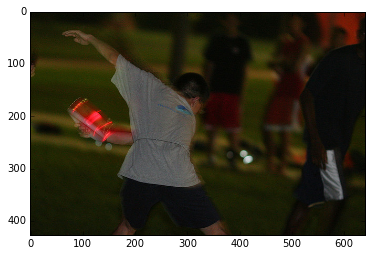

Valdation ImageId:  554625


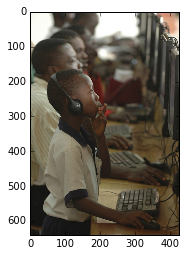


 NN in TrainingSet ImageId:  388830 ,  Index:  62842


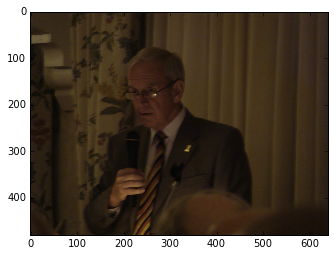

Valdation ImageId:  397133


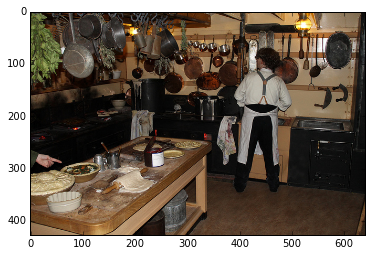


 NN in TrainingSet ImageId:  10369 ,  Index:  35329


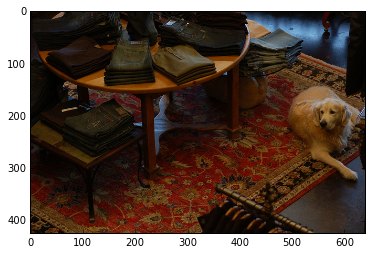

Valdation ImageId:  574769


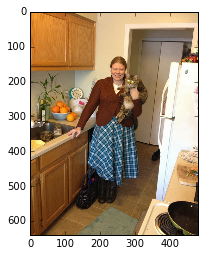


 NN in TrainingSet ImageId:  313285 ,  Index:  38950


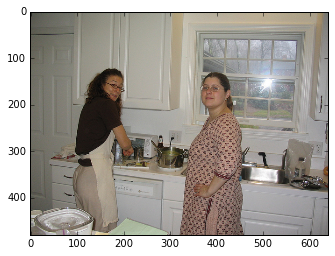

Valdation ImageId:  60623


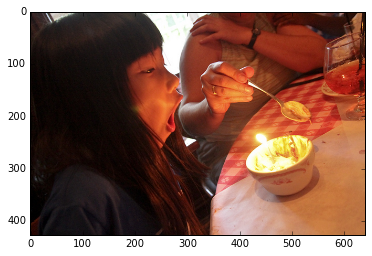


 NN in TrainingSet ImageId:  546311 ,  Index:  791


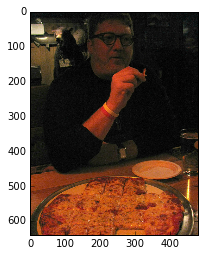

Valdation ImageId:  309022


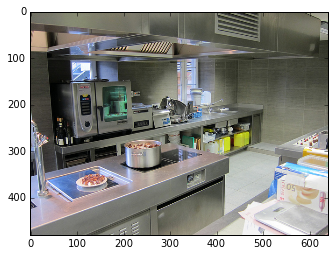


 NN in TrainingSet ImageId:  578915 ,  Index:  14340


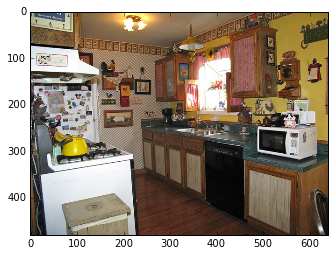

Valdation ImageId:  5802


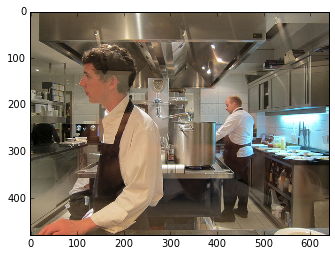


 NN in TrainingSet ImageId:  415232 ,  Index:  8220


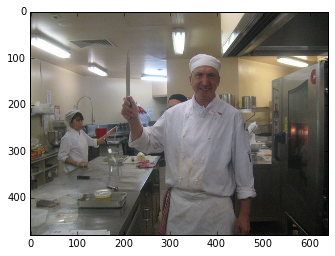

In [141]:
# -- Your code goes here --

#load the saved vectors from file (diabled here for speed)
loaded_validation_vectors = np.load('outputs/validation_vectors')
loaded_training_vectors = np.load('outputs/training_vectors')

for v, valFeat in enumerate(loaded_validation_vectors[:10]):
    DistanceForThisValFeat = []
    
    #calculate distances to all images in training set
    for traFeat in loaded_training_vectors[:]:
        DistanceForThisValFeat.append(np.linalg.norm(valFeat-traFeat))
    
    indexOfNN = np.argmin(DistanceForThisValFeat)
    
    #desplay the quary
    valImageId = val_ids[v]
    print("Valdation ImageId: ", valImageId)
    valImage = Image.open(val_id_to_file[valImageId]).convert('RGB')
    plt.imshow(valImage)
    plt.figure(valImageId)
    plt.show()
    
    
    #desplay the NearestNeigh
    traImageId = train_ids[indexOfNN]
    print("\n NN in TrainingSet ImageId: ", traImageId, ",  Index: ", indexOfNN)
    traImage = Image.open(train_id_to_file[traImageId]).convert('RGB')
    plt.imshow(traImage)
    plt.figure(traImageId)
    plt.show()

# 5. Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO. 

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512. 

In [199]:
# First we construct a class for the model
# -- Your code goes here --
class MyTwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MyTwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        h_sig1 = torch.sigmoid(self.linear1(x))
        y_pred = torch.sigmoid(self.linear2(h_sig1))
        return y_pred

model = MyTwoLayerNet(4096, 512, 91)
criterion = torch.nn.MultiLabelSoftMarginLoss()

In [221]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --
x = loaded_training_vectors
yy = []
for i in range(len(loaded_training_vectors)):
    traImageId = train_ids[i]
    cats = train_id_to_categories[traImageId]
    
    label = np.zeros(91, dtype=int)
    for val in cats:
        label[val] = 1
        
    yy.append(label)
    
y = np.array(yy)


def train(model, learning_rate=0.001, batch_size=100, epochs=5):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    # -- Your code goes here --
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    print("began training with: ", len(y), " training examples\n")
    
    nbBatches = int(len(y)/batch_size)
    print("calculated: ", nbBatches, " batches\n")
    
    for epoch in range(epochs):
        for batch in range(nbBatches):
            # Forward pass: Compute predicted y by passing x to the model
            limit = min((batch+batch_size), len(y))
            
            inputs = Variable(torch.from_numpy(x[batch:limit]))
            labels = Variable(torch.from_numpy(y[batch:limit]))
            inputs.cuda()
            labels.cuda()

            y_pred = model(inputs)

            # Compute and print loss
            loss = criterion(y_pred, labels.float())

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print("epoch: ",epoch, ", batch: ", batch,", produced loss of", loss.data[0])
   
    print('Finished Training')
    
# Finally train the model
train(model)

Finished Training
began training with:  82783  training examples

calculated:  827  batches

epoch:  0 , batch:  0 , produced loss of 0.7261931300163269
epoch:  0 , batch:  1 , produced loss of 0.7262102961540222
epoch:  0 , batch:  2 , produced loss of 0.7262410521507263
epoch:  0 , batch:  3 , produced loss of 0.7262786030769348
epoch:  0 , batch:  4 , produced loss of 0.7262324094772339
epoch:  0 , batch:  5 , produced loss of 0.726248025894165
epoch:  0 , batch:  6 , produced loss of 0.7261831760406494
epoch:  0 , batch:  7 , produced loss of 0.7261669635772705
epoch:  0 , batch:  8 , produced loss of 0.72613924741745
epoch:  0 , batch:  9 , produced loss of 0.7261696457862854
epoch:  0 , batch:  10 , produced loss of 0.7261884808540344
epoch:  0 , batch:  11 , produced loss of 0.7262341380119324
epoch:  0 , batch:  12 , produced loss of 0.7262550592422485
epoch:  0 , batch:  13 , produced loss of 0.7262609004974365
epoch:  0 , batch:  14 , produced loss of 0.7262740135192871
epoch

epoch:  0 , batch:  137 , produced loss of 0.7237768173217773
epoch:  0 , batch:  138 , produced loss of 0.7238321304321289
epoch:  0 , batch:  139 , produced loss of 0.7238633632659912
epoch:  0 , batch:  140 , produced loss of 0.7238627076148987
epoch:  0 , batch:  141 , produced loss of 0.7238668203353882
epoch:  0 , batch:  142 , produced loss of 0.7238196730613708
epoch:  0 , batch:  143 , produced loss of 0.7238443493843079
epoch:  0 , batch:  144 , produced loss of 0.7238995432853699
epoch:  0 , batch:  145 , produced loss of 0.7239145636558533
epoch:  0 , batch:  146 , produced loss of 0.7238788604736328
epoch:  0 , batch:  147 , produced loss of 0.7239021062850952
epoch:  0 , batch:  148 , produced loss of 0.7238732576370239
epoch:  0 , batch:  149 , produced loss of 0.7238838076591492
epoch:  0 , batch:  150 , produced loss of 0.7238804697990417
epoch:  0 , batch:  151 , produced loss of 0.7239171862602234
epoch:  0 , batch:  152 , produced loss of 0.7239293456077576
epoch:  

epoch:  0 , batch:  276 , produced loss of 0.72109454870224
epoch:  0 , batch:  277 , produced loss of 0.7210647463798523
epoch:  0 , batch:  278 , produced loss of 0.7211096882820129
epoch:  0 , batch:  279 , produced loss of 0.7210946679115295
epoch:  0 , batch:  280 , produced loss of 0.7210932970046997
epoch:  0 , batch:  281 , produced loss of 0.7211471199989319
epoch:  0 , batch:  282 , produced loss of 0.7211605310440063
epoch:  0 , batch:  283 , produced loss of 0.721157431602478
epoch:  0 , batch:  284 , produced loss of 0.7210953235626221
epoch:  0 , batch:  285 , produced loss of 0.7210712432861328
epoch:  0 , batch:  286 , produced loss of 0.7210506796836853
epoch:  0 , batch:  287 , produced loss of 0.7209976315498352
epoch:  0 , batch:  288 , produced loss of 0.7208829522132874
epoch:  0 , batch:  289 , produced loss of 0.7208876013755798
epoch:  0 , batch:  290 , produced loss of 0.7208545207977295
epoch:  0 , batch:  291 , produced loss of 0.7207766175270081
epoch:  0 ,

epoch:  0 , batch:  424 , produced loss of 0.7177552580833435
epoch:  0 , batch:  425 , produced loss of 0.7177250385284424
epoch:  0 , batch:  426 , produced loss of 0.7177061438560486
epoch:  0 , batch:  427 , produced loss of 0.7177608609199524
epoch:  0 , batch:  428 , produced loss of 0.7177433371543884
epoch:  0 , batch:  429 , produced loss of 0.7177354693412781
epoch:  0 , batch:  430 , produced loss of 0.7178264260292053
epoch:  0 , batch:  431 , produced loss of 0.7178245782852173
epoch:  0 , batch:  432 , produced loss of 0.7178443670272827
epoch:  0 , batch:  433 , produced loss of 0.7178346514701843
epoch:  0 , batch:  434 , produced loss of 0.7178547978401184
epoch:  0 , batch:  435 , produced loss of 0.7178244590759277
epoch:  0 , batch:  436 , produced loss of 0.7178244590759277
epoch:  0 , batch:  437 , produced loss of 0.7177920937538147
epoch:  0 , batch:  438 , produced loss of 0.7177366018295288
epoch:  0 , batch:  439 , produced loss of 0.7176752090454102
epoch:  

epoch:  0 , batch:  569 , produced loss of 0.715532124042511
epoch:  0 , batch:  570 , produced loss of 0.7155441045761108
epoch:  0 , batch:  571 , produced loss of 0.7155327796936035
epoch:  0 , batch:  572 , produced loss of 0.7155372500419617
epoch:  0 , batch:  573 , produced loss of 0.7154742479324341
epoch:  0 , batch:  574 , produced loss of 0.7154657244682312
epoch:  0 , batch:  575 , produced loss of 0.7154569625854492
epoch:  0 , batch:  576 , produced loss of 0.7154271006584167
epoch:  0 , batch:  577 , produced loss of 0.7153968214988708
epoch:  0 , batch:  578 , produced loss of 0.7153999209403992
epoch:  0 , batch:  579 , produced loss of 0.7153573036193848
epoch:  0 , batch:  580 , produced loss of 0.7153464555740356
epoch:  0 , batch:  581 , produced loss of 0.7153307199478149
epoch:  0 , batch:  582 , produced loss of 0.7153288722038269
epoch:  0 , batch:  583 , produced loss of 0.7152852416038513
epoch:  0 , batch:  584 , produced loss of 0.7152428030967712
epoch:  0

epoch:  0 , batch:  702 , produced loss of 0.7140031456947327
epoch:  0 , batch:  703 , produced loss of 0.714025616645813
epoch:  0 , batch:  704 , produced loss of 0.7140341401100159
epoch:  0 , batch:  705 , produced loss of 0.7139722108840942
epoch:  0 , batch:  706 , produced loss of 0.7139829397201538
epoch:  0 , batch:  707 , produced loss of 0.7140234112739563
epoch:  0 , batch:  708 , produced loss of 0.7140545845031738
epoch:  0 , batch:  709 , produced loss of 0.7140291333198547
epoch:  0 , batch:  710 , produced loss of 0.7140213847160339
epoch:  0 , batch:  711 , produced loss of 0.7139929533004761
epoch:  0 , batch:  712 , produced loss of 0.7139933109283447
epoch:  0 , batch:  713 , produced loss of 0.7139600515365601
epoch:  0 , batch:  714 , produced loss of 0.7139214873313904
epoch:  0 , batch:  715 , produced loss of 0.7138571739196777
epoch:  0 , batch:  716 , produced loss of 0.7138941884040833
epoch:  0 , batch:  717 , produced loss of 0.7138648629188538
epoch:  0

epoch:  1 , batch:  15 , produced loss of 0.7129226326942444
epoch:  1 , batch:  16 , produced loss of 0.7129539847373962
epoch:  1 , batch:  17 , produced loss of 0.7129672765731812
epoch:  1 , batch:  18 , produced loss of 0.7129587531089783
epoch:  1 , batch:  19 , produced loss of 0.7130077481269836
epoch:  1 , batch:  20 , produced loss of 0.7130250930786133
epoch:  1 , batch:  21 , produced loss of 0.7129839062690735
epoch:  1 , batch:  22 , produced loss of 0.7129667401313782
epoch:  1 , batch:  23 , produced loss of 0.7129881978034973
epoch:  1 , batch:  24 , produced loss of 0.7130257487297058
epoch:  1 , batch:  25 , produced loss of 0.7129815816879272
epoch:  1 , batch:  26 , produced loss of 0.7129020690917969
epoch:  1 , batch:  27 , produced loss of 0.7129124402999878
epoch:  1 , batch:  28 , produced loss of 0.7130166292190552
epoch:  1 , batch:  29 , produced loss of 0.7130137085914612
epoch:  1 , batch:  30 , produced loss of 0.7129958868026733
epoch:  1 , batch:  31 ,

epoch:  1 , batch:  150 , produced loss of 0.7119892835617065
epoch:  1 , batch:  151 , produced loss of 0.7120293378829956
epoch:  1 , batch:  152 , produced loss of 0.7120462656021118
epoch:  1 , batch:  153 , produced loss of 0.712076723575592
epoch:  1 , batch:  154 , produced loss of 0.7120966911315918
epoch:  1 , batch:  155 , produced loss of 0.7120621800422668
epoch:  1 , batch:  156 , produced loss of 0.712056040763855
epoch:  1 , batch:  157 , produced loss of 0.7120459675788879
epoch:  1 , batch:  158 , produced loss of 0.7120748162269592
epoch:  1 , batch:  159 , produced loss of 0.712115466594696
epoch:  1 , batch:  160 , produced loss of 0.7121263742446899
epoch:  1 , batch:  161 , produced loss of 0.7121424674987793
epoch:  1 , batch:  162 , produced loss of 0.712112545967102
epoch:  1 , batch:  163 , produced loss of 0.7121179103851318
epoch:  1 , batch:  164 , produced loss of 0.7121189832687378
epoch:  1 , batch:  165 , produced loss of 0.712159276008606
epoch:  1 , b

epoch:  1 , batch:  286 , produced loss of 0.7107434868812561
epoch:  1 , batch:  287 , produced loss of 0.710704505443573
epoch:  1 , batch:  288 , produced loss of 0.7106174826622009
epoch:  1 , batch:  289 , produced loss of 0.710631251335144
epoch:  1 , batch:  290 , produced loss of 0.7106102108955383
epoch:  1 , batch:  291 , produced loss of 0.7105585336685181
epoch:  1 , batch:  292 , produced loss of 0.7105226516723633
epoch:  1 , batch:  293 , produced loss of 0.7105555534362793
epoch:  1 , batch:  294 , produced loss of 0.7105394005775452
epoch:  1 , batch:  295 , produced loss of 0.7104817628860474
epoch:  1 , batch:  296 , produced loss of 0.7104378342628479
epoch:  1 , batch:  297 , produced loss of 0.710425078868866
epoch:  1 , batch:  298 , produced loss of 0.7105032205581665
epoch:  1 , batch:  299 , produced loss of 0.7104750275611877
epoch:  1 , batch:  300 , produced loss of 0.7104970216751099
epoch:  1 , batch:  301 , produced loss of 0.7104640007019043
epoch:  1 ,

epoch:  1 , batch:  422 , produced loss of 0.708929717540741
epoch:  1 , batch:  423 , produced loss of 0.7089222073554993
epoch:  1 , batch:  424 , produced loss of 0.7088817954063416
epoch:  1 , batch:  425 , produced loss of 0.708864152431488
epoch:  1 , batch:  426 , produced loss of 0.7088601589202881
epoch:  1 , batch:  427 , produced loss of 0.708914041519165
epoch:  1 , batch:  428 , produced loss of 0.7089073061943054
epoch:  1 , batch:  429 , produced loss of 0.7089037299156189
epoch:  1 , batch:  430 , produced loss of 0.708986759185791
epoch:  1 , batch:  431 , produced loss of 0.7089932560920715
epoch:  1 , batch:  432 , produced loss of 0.7090204358100891
epoch:  1 , batch:  433 , produced loss of 0.7090213894844055
epoch:  1 , batch:  434 , produced loss of 0.7090435028076172
epoch:  1 , batch:  435 , produced loss of 0.7090222239494324
epoch:  1 , batch:  436 , produced loss of 0.7090244889259338
epoch:  1 , batch:  437 , produced loss of 0.7090075612068176
epoch:  1 , 

epoch:  1 , batch:  569 , produced loss of 0.7078317999839783
epoch:  1 , batch:  570 , produced loss of 0.7078470587730408
epoch:  1 , batch:  571 , produced loss of 0.7078456282615662
epoch:  1 , batch:  572 , produced loss of 0.7078525424003601
epoch:  1 , batch:  573 , produced loss of 0.707804262638092
epoch:  1 , batch:  574 , produced loss of 0.7078050971031189
epoch:  1 , batch:  575 , produced loss of 0.7078038454055786
epoch:  1 , batch:  576 , produced loss of 0.7077877521514893
epoch:  1 , batch:  577 , produced loss of 0.7077709436416626
epoch:  1 , batch:  578 , produced loss of 0.7077791094779968
epoch:  1 , batch:  579 , produced loss of 0.7077499032020569
epoch:  1 , batch:  580 , produced loss of 0.7077472805976868
epoch:  1 , batch:  581 , produced loss of 0.7077347636222839
epoch:  1 , batch:  582 , produced loss of 0.7077334523200989
epoch:  1 , batch:  583 , produced loss of 0.7076991200447083
epoch:  1 , batch:  584 , produced loss of 0.7076669335365295
epoch:  1

epoch:  1 , batch:  717 , produced loss of 0.7071362137794495
epoch:  1 , batch:  718 , produced loss of 0.7071718573570251
epoch:  1 , batch:  719 , produced loss of 0.7072003483772278
epoch:  1 , batch:  720 , produced loss of 0.707191526889801
epoch:  1 , batch:  721 , produced loss of 0.7072200775146484
epoch:  1 , batch:  722 , produced loss of 0.7072303891181946
epoch:  1 , batch:  723 , produced loss of 0.7072410583496094
epoch:  1 , batch:  724 , produced loss of 0.7072202563285828
epoch:  1 , batch:  725 , produced loss of 0.7072365283966064
epoch:  1 , batch:  726 , produced loss of 0.7072353363037109
epoch:  1 , batch:  727 , produced loss of 0.7071976661682129
epoch:  1 , batch:  728 , produced loss of 0.7071912884712219
epoch:  1 , batch:  729 , produced loss of 0.7071958184242249
epoch:  1 , batch:  730 , produced loss of 0.7071754932403564
epoch:  1 , batch:  731 , produced loss of 0.7071030735969543
epoch:  1 , batch:  732 , produced loss of 0.7070666551589966
epoch:  1

epoch:  2 , batch:  27 , produced loss of 0.7068426609039307
epoch:  2 , batch:  28 , produced loss of 0.7069321274757385
epoch:  2 , batch:  29 , produced loss of 0.7069374322891235
epoch:  2 , batch:  30 , produced loss of 0.7069243788719177
epoch:  2 , batch:  31 , produced loss of 0.7069605588912964
epoch:  2 , batch:  32 , produced loss of 0.7069733738899231
epoch:  2 , batch:  33 , produced loss of 0.7069384455680847
epoch:  2 , batch:  34 , produced loss of 0.7069012522697449
epoch:  2 , batch:  35 , produced loss of 0.7068815231323242
epoch:  2 , batch:  36 , produced loss of 0.706855058670044
epoch:  2 , batch:  37 , produced loss of 0.7068527936935425
epoch:  2 , batch:  38 , produced loss of 0.7068465352058411
epoch:  2 , batch:  39 , produced loss of 0.7068483829498291
epoch:  2 , batch:  40 , produced loss of 0.7068341374397278
epoch:  2 , batch:  41 , produced loss of 0.7068602442741394
epoch:  2 , batch:  42 , produced loss of 0.7068605422973633
epoch:  2 , batch:  43 , 

epoch:  2 , batch:  168 , produced loss of 0.7066071033477783
epoch:  2 , batch:  169 , produced loss of 0.706572949886322
epoch:  2 , batch:  170 , produced loss of 0.7065894603729248
epoch:  2 , batch:  171 , produced loss of 0.706573486328125
epoch:  2 , batch:  172 , produced loss of 0.7066087126731873
epoch:  2 , batch:  173 , produced loss of 0.7066220045089722
epoch:  2 , batch:  174 , produced loss of 0.7066271305084229
epoch:  2 , batch:  175 , produced loss of 0.7066061496734619
epoch:  2 , batch:  176 , produced loss of 0.7066306471824646
epoch:  2 , batch:  177 , produced loss of 0.7066685557365417
epoch:  2 , batch:  178 , produced loss of 0.7066213488578796
epoch:  2 , batch:  179 , produced loss of 0.706599235534668
epoch:  2 , batch:  180 , produced loss of 0.7065925002098083
epoch:  2 , batch:  181 , produced loss of 0.7065330743789673
epoch:  2 , batch:  182 , produced loss of 0.7065528035163879
epoch:  2 , batch:  183 , produced loss of 0.7065316438674927
epoch:  2 ,

epoch:  2 , batch:  305 , produced loss of 0.7053929567337036
epoch:  2 , batch:  306 , produced loss of 0.7053712010383606
epoch:  2 , batch:  307 , produced loss of 0.705341100692749
epoch:  2 , batch:  308 , produced loss of 0.705341637134552
epoch:  2 , batch:  309 , produced loss of 0.7053136825561523
epoch:  2 , batch:  310 , produced loss of 0.7053505778312683
epoch:  2 , batch:  311 , produced loss of 0.7053505778312683
epoch:  2 , batch:  312 , produced loss of 0.7053436040878296
epoch:  2 , batch:  313 , produced loss of 0.7053003907203674
epoch:  2 , batch:  314 , produced loss of 0.705228328704834
epoch:  2 , batch:  315 , produced loss of 0.7052468657493591
epoch:  2 , batch:  316 , produced loss of 0.7052428722381592
epoch:  2 , batch:  317 , produced loss of 0.705250084400177
epoch:  2 , batch:  318 , produced loss of 0.7052268981933594
epoch:  2 , batch:  319 , produced loss of 0.7052380442619324
epoch:  2 , batch:  320 , produced loss of 0.7052649855613708
epoch:  2 , 

epoch:  2 , batch:  444 , produced loss of 0.7044386267662048
epoch:  2 , batch:  445 , produced loss of 0.7044575214385986
epoch:  2 , batch:  446 , produced loss of 0.7044907808303833
epoch:  2 , batch:  447 , produced loss of 0.7044810652732849
epoch:  2 , batch:  448 , produced loss of 0.7044516801834106
epoch:  2 , batch:  449 , produced loss of 0.7044656872749329
epoch:  2 , batch:  450 , produced loss of 0.7044721245765686
epoch:  2 , batch:  451 , produced loss of 0.7044828534126282
epoch:  2 , batch:  452 , produced loss of 0.7044631242752075
epoch:  2 , batch:  453 , produced loss of 0.7044928669929504
epoch:  2 , batch:  454 , produced loss of 0.7045048475265503
epoch:  2 , batch:  455 , produced loss of 0.7044821977615356
epoch:  2 , batch:  456 , produced loss of 0.7044320106506348
epoch:  2 , batch:  457 , produced loss of 0.7044374346733093
epoch:  2 , batch:  458 , produced loss of 0.7044514417648315
epoch:  2 , batch:  459 , produced loss of 0.7044450044631958
epoch:  

epoch:  2 , batch:  579 , produced loss of 0.7037748098373413
epoch:  2 , batch:  580 , produced loss of 0.7037743330001831
epoch:  2 , batch:  581 , produced loss of 0.7037627100944519
epoch:  2 , batch:  582 , produced loss of 0.7037615180015564
epoch:  2 , batch:  583 , produced loss of 0.7037312984466553
epoch:  2 , batch:  584 , produced loss of 0.7037047743797302
epoch:  2 , batch:  585 , produced loss of 0.7037318348884583
epoch:  2 , batch:  586 , produced loss of 0.703738272190094
epoch:  2 , batch:  587 , produced loss of 0.7037155032157898
epoch:  2 , batch:  588 , produced loss of 0.7037068009376526
epoch:  2 , batch:  589 , produced loss of 0.7037252187728882
epoch:  2 , batch:  590 , produced loss of 0.7036792635917664
epoch:  2 , batch:  591 , produced loss of 0.7036533951759338
epoch:  2 , batch:  592 , produced loss of 0.7036586999893188
epoch:  2 , batch:  593 , produced loss of 0.7036527991294861
epoch:  2 , batch:  594 , produced loss of 0.7036686539649963
epoch:  2

epoch:  2 , batch:  718 , produced loss of 0.7035375833511353
epoch:  2 , batch:  719 , produced loss of 0.7035638689994812
epoch:  2 , batch:  720 , produced loss of 0.7035585045814514
epoch:  2 , batch:  721 , produced loss of 0.7035818099975586
epoch:  2 , batch:  722 , produced loss of 0.7035916447639465
epoch:  2 , batch:  723 , produced loss of 0.7036008238792419
epoch:  2 , batch:  724 , produced loss of 0.7035846710205078
epoch:  2 , batch:  725 , produced loss of 0.7035979628562927
epoch:  2 , batch:  726 , produced loss of 0.7036004066467285
epoch:  2 , batch:  727 , produced loss of 0.7035706639289856
epoch:  2 , batch:  728 , produced loss of 0.7035673260688782
epoch:  2 , batch:  729 , produced loss of 0.70357346534729
epoch:  2 , batch:  730 , produced loss of 0.7035593390464783
epoch:  2 , batch:  731 , produced loss of 0.7034993171691895
epoch:  2 , batch:  732 , produced loss of 0.7034726738929749
epoch:  2 , batch:  733 , produced loss of 0.703464925289154
epoch:  2 ,

epoch:  3 , batch:  29 , produced loss of 0.7035719752311707
epoch:  3 , batch:  30 , produced loss of 0.7035617828369141
epoch:  3 , batch:  31 , produced loss of 0.7035938501358032
epoch:  3 , batch:  32 , produced loss of 0.703607439994812
epoch:  3 , batch:  33 , produced loss of 0.7035767436027527
epoch:  3 , batch:  34 , produced loss of 0.7035425901412964
epoch:  3 , batch:  35 , produced loss of 0.7035256028175354
epoch:  3 , batch:  36 , produced loss of 0.7035037279129028
epoch:  3 , batch:  37 , produced loss of 0.7035048007965088
epoch:  3 , batch:  38 , produced loss of 0.7035006880760193
epoch:  3 , batch:  39 , produced loss of 0.7035058736801147
epoch:  3 , batch:  40 , produced loss of 0.7034934759140015
epoch:  3 , batch:  41 , produced loss of 0.7035161256790161
epoch:  3 , batch:  42 , produced loss of 0.7035179734230042
epoch:  3 , batch:  43 , produced loss of 0.7034873962402344
epoch:  3 , batch:  44 , produced loss of 0.7035176157951355
epoch:  3 , batch:  45 , 

epoch:  3 , batch:  171 , produced loss of 0.7034018635749817
epoch:  3 , batch:  172 , produced loss of 0.7034332752227783
epoch:  3 , batch:  173 , produced loss of 0.7034468650817871
epoch:  3 , batch:  174 , produced loss of 0.7034531831741333
epoch:  3 , batch:  175 , produced loss of 0.7034366130828857
epoch:  3 , batch:  176 , produced loss of 0.7034589648246765
epoch:  3 , batch:  177 , produced loss of 0.7034933567047119
epoch:  3 , batch:  178 , produced loss of 0.7034541368484497
epoch:  3 , batch:  179 , produced loss of 0.7034366130828857
epoch:  3 , batch:  180 , produced loss of 0.7034330368041992
epoch:  3 , batch:  181 , produced loss of 0.7033818364143372
epoch:  3 , batch:  182 , produced loss of 0.7034006118774414
epoch:  3 , batch:  183 , produced loss of 0.7033823132514954
epoch:  3 , batch:  184 , produced loss of 0.703392505645752
epoch:  3 , batch:  185 , produced loss of 0.7033764719963074
epoch:  3 , batch:  186 , produced loss of 0.7033326029777527
epoch:  3

epoch:  3 , batch:  313 , produced loss of 0.7024453282356262
epoch:  3 , batch:  314 , produced loss of 0.7023842930793762
epoch:  3 , batch:  315 , produced loss of 0.702400267124176
epoch:  3 , batch:  316 , produced loss of 0.7023975253105164
epoch:  3 , batch:  317 , produced loss of 0.7024052739143372
epoch:  3 , batch:  318 , produced loss of 0.7023855447769165
epoch:  3 , batch:  319 , produced loss of 0.7023962736129761
epoch:  3 , batch:  320 , produced loss of 0.7024195790290833
epoch:  3 , batch:  321 , produced loss of 0.7024158835411072
epoch:  3 , batch:  322 , produced loss of 0.702399492263794
epoch:  3 , batch:  323 , produced loss of 0.7023946046829224
epoch:  3 , batch:  324 , produced loss of 0.7023983001708984
epoch:  3 , batch:  325 , produced loss of 0.7024150490760803
epoch:  3 , batch:  326 , produced loss of 0.7024168968200684
epoch:  3 , batch:  327 , produced loss of 0.7023676037788391
epoch:  3 , batch:  328 , produced loss of 0.7023767232894897
epoch:  3 

epoch:  3 , batch:  456 , produced loss of 0.7018475532531738
epoch:  3 , batch:  457 , produced loss of 0.7018539905548096
epoch:  3 , batch:  458 , produced loss of 0.7018671631813049
epoch:  3 , batch:  459 , produced loss of 0.7018643617630005
epoch:  3 , batch:  460 , produced loss of 0.7018837928771973
epoch:  3 , batch:  461 , produced loss of 0.7018671035766602
epoch:  3 , batch:  462 , produced loss of 0.7018659710884094
epoch:  3 , batch:  463 , produced loss of 0.7018387913703918
epoch:  3 , batch:  464 , produced loss of 0.7018685340881348
epoch:  3 , batch:  465 , produced loss of 0.7018696665763855
epoch:  3 , batch:  466 , produced loss of 0.7018749713897705
epoch:  3 , batch:  467 , produced loss of 0.7018603086471558
epoch:  3 , batch:  468 , produced loss of 0.7018771767616272
epoch:  3 , batch:  469 , produced loss of 0.7019038200378418
epoch:  3 , batch:  470 , produced loss of 0.7018634080886841
epoch:  3 , batch:  471 , produced loss of 0.7018193602561951
epoch:  

epoch:  3 , batch:  604 , produced loss of 0.7013704180717468
epoch:  3 , batch:  605 , produced loss of 0.7013716697692871
epoch:  3 , batch:  606 , produced loss of 0.7013330459594727
epoch:  3 , batch:  607 , produced loss of 0.701320469379425
epoch:  3 , batch:  608 , produced loss of 0.7013401985168457
epoch:  3 , batch:  609 , produced loss of 0.7013030648231506
epoch:  3 , batch:  610 , produced loss of 0.7012910842895508
epoch:  3 , batch:  611 , produced loss of 0.7012885808944702
epoch:  3 , batch:  612 , produced loss of 0.7012901902198792
epoch:  3 , batch:  613 , produced loss of 0.7012953162193298
epoch:  3 , batch:  614 , produced loss of 0.7012835144996643
epoch:  3 , batch:  615 , produced loss of 0.7012934684753418
epoch:  3 , batch:  616 , produced loss of 0.7012754678726196
epoch:  3 , batch:  617 , produced loss of 0.701259434223175
epoch:  3 , batch:  618 , produced loss of 0.7012445330619812
epoch:  3 , batch:  619 , produced loss of 0.7012088298797607
epoch:  3 

epoch:  3 , batch:  744 , produced loss of 0.7010735869407654
epoch:  3 , batch:  745 , produced loss of 0.7010588049888611
epoch:  3 , batch:  746 , produced loss of 0.7010718584060669
epoch:  3 , batch:  747 , produced loss of 0.7010870575904846
epoch:  3 , batch:  748 , produced loss of 0.7010888457298279
epoch:  3 , batch:  749 , produced loss of 0.7010424733161926
epoch:  3 , batch:  750 , produced loss of 0.7010414600372314
epoch:  3 , batch:  751 , produced loss of 0.7010540962219238
epoch:  3 , batch:  752 , produced loss of 0.7011060118675232
epoch:  3 , batch:  753 , produced loss of 0.7011114954948425
epoch:  3 , batch:  754 , produced loss of 0.7010895013809204
epoch:  3 , batch:  755 , produced loss of 0.7011270523071289
epoch:  3 , batch:  756 , produced loss of 0.7011376023292542
epoch:  3 , batch:  757 , produced loss of 0.7010842561721802
epoch:  3 , batch:  758 , produced loss of 0.7011204361915588
epoch:  3 , batch:  759 , produced loss of 0.7010902166366577
epoch:  

epoch:  4 , batch:  52 , produced loss of 0.701415479183197
epoch:  4 , batch:  53 , produced loss of 0.701417863368988
epoch:  4 , batch:  54 , produced loss of 0.7013944387435913
epoch:  4 , batch:  55 , produced loss of 0.7014240622520447
epoch:  4 , batch:  56 , produced loss of 0.7014150023460388
epoch:  4 , batch:  57 , produced loss of 0.7014155387878418
epoch:  4 , batch:  58 , produced loss of 0.7014073133468628
epoch:  4 , batch:  59 , produced loss of 0.7013930082321167
epoch:  4 , batch:  60 , produced loss of 0.7014042139053345
epoch:  4 , batch:  61 , produced loss of 0.7013848423957825
epoch:  4 , batch:  62 , produced loss of 0.7013779282569885
epoch:  4 , batch:  63 , produced loss of 0.7013428211212158
epoch:  4 , batch:  64 , produced loss of 0.7013295888900757
epoch:  4 , batch:  65 , produced loss of 0.7012717723846436
epoch:  4 , batch:  66 , produced loss of 0.7012817859649658
epoch:  4 , batch:  67 , produced loss of 0.7012823820114136
epoch:  4 , batch:  68 , p

epoch:  4 , batch:  202 , produced loss of 0.701269268989563
epoch:  4 , batch:  203 , produced loss of 0.7012721300125122
epoch:  4 , batch:  204 , produced loss of 0.701261043548584
epoch:  4 , batch:  205 , produced loss of 0.7012727856636047
epoch:  4 , batch:  206 , produced loss of 0.7012838125228882
epoch:  4 , batch:  207 , produced loss of 0.7012778520584106
epoch:  4 , batch:  208 , produced loss of 0.7012530565261841
epoch:  4 , batch:  209 , produced loss of 0.7012544274330139
epoch:  4 , batch:  210 , produced loss of 0.7012279033660889
epoch:  4 , batch:  211 , produced loss of 0.7012028098106384
epoch:  4 , batch:  212 , produced loss of 0.7012409567832947
epoch:  4 , batch:  213 , produced loss of 0.7012788653373718
epoch:  4 , batch:  214 , produced loss of 0.7013005018234253
epoch:  4 , batch:  215 , produced loss of 0.7012993693351746
epoch:  4 , batch:  216 , produced loss of 0.7013196349143982
epoch:  4 , batch:  217 , produced loss of 0.7013089060783386
epoch:  4 

epoch:  4 , batch:  345 , produced loss of 0.7003944516181946
epoch:  4 , batch:  346 , produced loss of 0.7003914713859558
epoch:  4 , batch:  347 , produced loss of 0.7003952264785767
epoch:  4 , batch:  348 , produced loss of 0.7003806233406067
epoch:  4 , batch:  349 , produced loss of 0.7003733515739441
epoch:  4 , batch:  350 , produced loss of 0.7003466486930847
epoch:  4 , batch:  351 , produced loss of 0.700347900390625
epoch:  4 , batch:  352 , produced loss of 0.7003368139266968
epoch:  4 , batch:  353 , produced loss of 0.7003524303436279
epoch:  4 , batch:  354 , produced loss of 0.7003610134124756
epoch:  4 , batch:  355 , produced loss of 0.7003520727157593
epoch:  4 , batch:  356 , produced loss of 0.7003578543663025
epoch:  4 , batch:  357 , produced loss of 0.700348436832428
epoch:  4 , batch:  358 , produced loss of 0.7003651261329651
epoch:  4 , batch:  359 , produced loss of 0.7003673911094666
epoch:  4 , batch:  360 , produced loss of 0.7003355622291565
epoch:  4 

epoch:  4 , batch:  490 , produced loss of 0.7002688646316528
epoch:  4 , batch:  491 , produced loss of 0.7002851366996765
epoch:  4 , batch:  492 , produced loss of 0.7003083825111389
epoch:  4 , batch:  493 , produced loss of 0.7003313899040222
epoch:  4 , batch:  494 , produced loss of 0.7003241181373596
epoch:  4 , batch:  495 , produced loss of 0.7003222703933716
epoch:  4 , batch:  496 , produced loss of 0.7003303170204163
epoch:  4 , batch:  497 , produced loss of 0.7003122568130493
epoch:  4 , batch:  498 , produced loss of 0.7003047466278076
epoch:  4 , batch:  499 , produced loss of 0.7003093957901001
epoch:  4 , batch:  500 , produced loss of 0.7003081440925598
epoch:  4 , batch:  501 , produced loss of 0.7002617120742798
epoch:  4 , batch:  502 , produced loss of 0.7002542614936829
epoch:  4 , batch:  503 , produced loss of 0.7002822160720825
epoch:  4 , batch:  504 , produced loss of 0.7002568244934082
epoch:  4 , batch:  505 , produced loss of 0.7002589106559753
epoch:  

epoch:  4 , batch:  643 , produced loss of 0.6996217966079712
epoch:  4 , batch:  644 , produced loss of 0.6996546983718872
epoch:  4 , batch:  645 , produced loss of 0.6996454000473022
epoch:  4 , batch:  646 , produced loss of 0.6996435523033142
epoch:  4 , batch:  647 , produced loss of 0.6996235847473145
epoch:  4 , batch:  648 , produced loss of 0.6996300220489502
epoch:  4 , batch:  649 , produced loss of 0.6996656656265259
epoch:  4 , batch:  650 , produced loss of 0.6996173858642578
epoch:  4 , batch:  651 , produced loss of 0.6996045708656311
epoch:  4 , batch:  652 , produced loss of 0.6995924711227417
epoch:  4 , batch:  653 , produced loss of 0.6995832324028015
epoch:  4 , batch:  654 , produced loss of 0.6995865702629089
epoch:  4 , batch:  655 , produced loss of 0.6995807886123657
epoch:  4 , batch:  656 , produced loss of 0.6995760202407837
epoch:  4 , batch:  657 , produced loss of 0.6996182203292847
epoch:  4 , batch:  658 , produced loss of 0.6995977163314819
epoch:  

epoch:  4 , batch:  779 , produced loss of 0.6993894577026367
epoch:  4 , batch:  780 , produced loss of 0.6993755102157593
epoch:  4 , batch:  781 , produced loss of 0.6993781328201294
epoch:  4 , batch:  782 , produced loss of 0.6993852853775024
epoch:  4 , batch:  783 , produced loss of 0.6994163990020752
epoch:  4 , batch:  784 , produced loss of 0.6994364857673645
epoch:  4 , batch:  785 , produced loss of 0.6994233727455139
epoch:  4 , batch:  786 , produced loss of 0.6993992328643799
epoch:  4 , batch:  787 , produced loss of 0.6993955969810486
epoch:  4 , batch:  788 , produced loss of 0.6994010806083679
epoch:  4 , batch:  789 , produced loss of 0.6994227766990662
epoch:  4 , batch:  790 , produced loss of 0.6994096636772156
epoch:  4 , batch:  791 , produced loss of 0.6994037628173828
epoch:  4 , batch:  792 , produced loss of 0.6993961334228516
epoch:  4 , batch:  793 , produced loss of 0.6993953585624695
epoch:  4 , batch:  794 , produced loss of 0.6993808150291443
epoch:  

Valdation ImageId:  391895


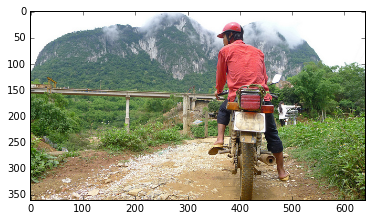

Actual Labels:
0. person
1. bicycle
2. motorcycle

Predicted Labels:
bicycle    **prob:  0.1673152595758438
cell phone    **prob:  0.020139705389738083
motorcycle    **prob:  0.016544081270694733
bed    **prob:  0.0163456778973341
apple    **prob:  0.015969999134540558



Valdation ImageId:  522418


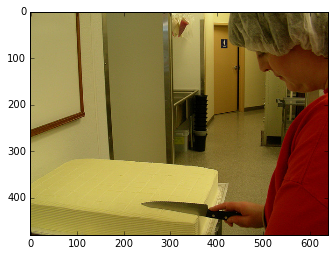

Actual Labels:
0. sink
1. person
2. cake
3. knife

Predicted Labels:
bicycle    **prob:  0.16342169046401978
cell phone    **prob:  0.02184489741921425
motorcycle    **prob:  0.01704419031739235
apple    **prob:  0.016603942960500717
bed    **prob:  0.016525952145457268



Valdation ImageId:  184613


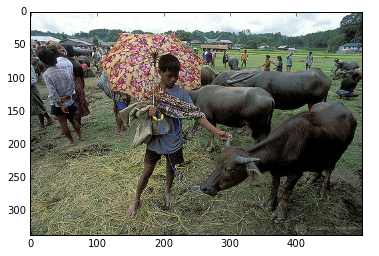

Actual Labels:
0. person
1. umbrella
2. cow

Predicted Labels:
bicycle    **prob:  0.16623400151729584
cell phone    **prob:  0.01919163204729557
motorcycle    **prob:  0.014711684547364712
bed    **prob:  0.014012642204761505
tie    **prob:  0.013909767381846905



Valdation ImageId:  318219


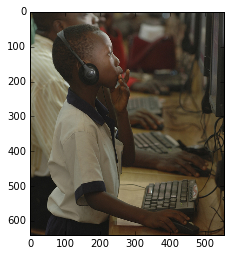

Actual Labels:
0. tv
1. person
2. mouse
3. keyboard

Predicted Labels:
bicycle    **prob:  0.17331472039222717
cell phone    **prob:  0.02275463379919529
motorcycle    **prob:  0.017916783690452576
tv    **prob:  0.01769718900322914
apple    **prob:  0.017527341842651367



Valdation ImageId:  554625


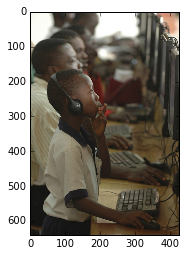

Actual Labels:
0. tv
1. person
2. mouse
3. keyboard

Predicted Labels:
bicycle    **prob:  0.18053124845027924
cell phone    **prob:  0.023749113082885742
motorcycle    **prob:  0.018866633996367455
tv    **prob:  0.01836213283240795
apple    **prob:  0.018292304128408432



Valdation ImageId:  397133


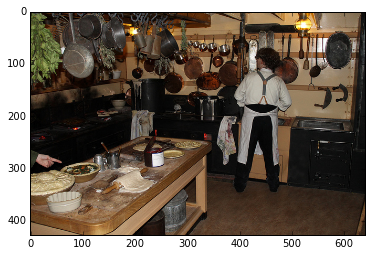

Actual Labels:
0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot

Predicted Labels:
bicycle    **prob:  0.16490520536899567
cell phone    **prob:  0.019336486235260963
bed    **prob:  0.014781387522816658
motorcycle    **prob:  0.014010955579578876
tie    **prob:  0.013923535123467445



Valdation ImageId:  574769


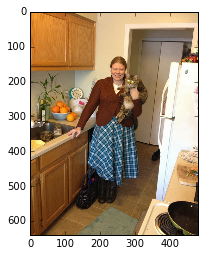

Actual Labels:
0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag

Predicted Labels:
bicycle    **prob:  0.17528162896633148
cell phone    **prob:  0.02463740110397339
bed    **prob:  0.020466985180974007
apple    **prob:  0.020069120451807976
motorcycle    **prob:  0.019793739542365074



Valdation ImageId:  60623


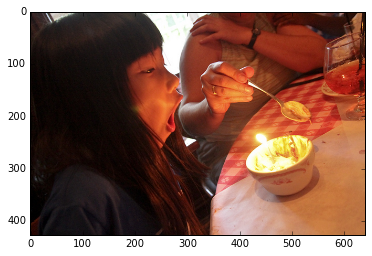

Actual Labels:
0. dining table
1. person
2. spoon
3. bowl
4. wine glass

Predicted Labels:
bicycle    **prob:  0.1665649563074112
cell phone    **prob:  0.020898275077342987
motorcycle    **prob:  0.017485300078988075
apple    **prob:  0.016008276492357254
bed    **prob:  0.015949666500091553



Valdation ImageId:  309022


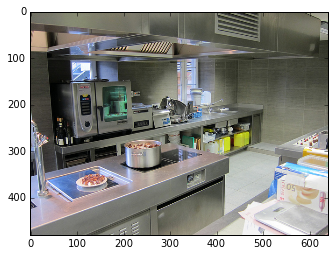

Actual Labels:
0. sink
1. bowl
2. bottle
3. oven

Predicted Labels:
bicycle    **prob:  0.1645338386297226
cell phone    **prob:  0.022690460085868835
spoon    **prob:  0.01851954683661461
apple    **prob:  0.017918536439538002
broccoli    **prob:  0.017731282860040665



Valdation ImageId:  5802


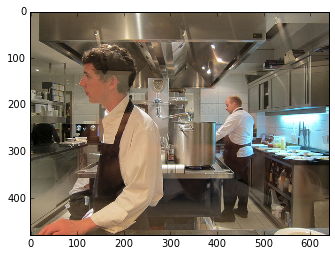

Actual Labels:
0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack

Predicted Labels:
bicycle    **prob:  0.17036990821361542
cell phone    **prob:  0.0207052081823349
motorcycle    **prob:  0.015923665836453438
bed    **prob:  0.015214361250400543
tv    **prob:  0.015195291489362717





In [245]:
# Now repeat step two using the two layer classifier.
# -- Your code goes here --
#Build the validation set
ValidationSet = Variable(torch.from_numpy(loaded_validation_vectors[:10]))

for v, valFeat in enumerate(ValidationSet[:]):
    ######## desplay the quary ######
    valImageId = val_ids[v]
    print("Valdation ImageId: ", valImageId)
    valImage = Image.open(val_id_to_file[valImageId]).convert('RGB')
    plt.imshow(valImage)
    plt.figure(valImageId)
    plt.show()
    ##################################
    
    
    ###### print actual labels ######    
    print("Actual Labels:")
    for iii,category in enumerate(val_id_to_categories[valImageId]):
        print("%d. %s" % (iii, category_to_name[category]))
    ##################################
    
  
    ##### print predicted labels #####
    prediction = model(valFeat)
    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = prediction.topk(5)
    
    print("\nPredicted Labels:")
    for p, i in zip(probs,indices):
        temp = i.cpu().data
        temp = temp.numpy()
        tempP = p.cpu().data
        tempP = tempP.numpy()
        print(category_idx_to_name[int(temp)], "   **prob: ", float(tempP))
    ##################################
    
    print("\n\n")

# comment on quality of results:

# 6. End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing. 

In [4]:
# First we construct a class for the model
# -- Your code goes here --
class MyEndToEndModel(nn.Module):

    def __init__(self):
        super(MyEndToEndModel, self).__init__()
        self.endToEnd_model = models.vgg16(pretrained=True)
        self.endToEnd_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, 512),
            nn.Sigmoid(),
            nn.Linear(512, 91),
        )
        
    def forward(self, images):
        x = self.endToEnd_model.features(images)
        x = x.view(x.size(0), -1)
        x = self.endToEnd_model.classifier(x)
        return x
    
    def save_checkpoint(self, state, is_best, filename='MyEndToEndModel_checkpoint.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'MyEndToEndModel_best.pth.tar')
    

model = MyEndToEndModel()
model.eval()
model.cuda() #remove .cuda to not put model on GPU can use .cuda(device_id=0) for specific gpu

MyEndToEndModel (
  (endToEnd_model): VGG (
    (features): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU (inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU (inplace)
      (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU (inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU (inplace)
      (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU (inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU (inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU (inplace)
      (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilatio

In [5]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --
#my data class to load the dataset
class hsDatasetCl(torch.utils.data.Dataset):

    def __init__(self, dataIds):
        self.dataIds = dataIds
        self.transform = transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        
    def load_imageHS(self, filename):
        image = Image.open(filename).convert('RGB')
        image_tensor = self.transform(image).float()
        #image_var = Variable(image_tensor).unsqueeze(0)
        return image_tensor

    def __len__(self):
        return len(self.dataIds)

    def __getitem__(self, idx):
        return self.load_imageHS(train_id_to_file[self.dataIds[idx]])
    

#load training data
trainingset = hsDatasetCl(train_ids)
#create labels
yy = []
for i in range(82783):
    traImageId = train_ids[i]
    cats = train_id_to_categories[traImageId]
    
    label = np.zeros(91, dtype=int)
    for val in cats:
        label[val] = 1
        
    yy.append(label)
    
y = np.array(yy)


#define a dataLoader for data and labels
trainingsetLoader = torch.utils.data.DataLoader(trainingset, batch_size=50,
                        shuffle=False, num_workers=2)

trainingsetLabelLoader = torch.utils.data.DataLoader(y, batch_size=50,
                        shuffle=False, num_workers=2)


        
def train(model, learning_rate=0.001, batch_size=50, epochs=2):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    # -- Your code goes here --
    criterion = torch.nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sigmoid = nn.Sigmoid()
    
    for epoch in range(2):  # loop over the dataset multiple times
        for i, (data, label) in enumerate(zip(trainingsetLoader, trainingsetLabelLoader)):
            # wrap the data and labels from each batch in Variables
            inputs = Variable(data.cuda()) #remove .cuda to not put model on GPU
            labels = Variable(label.cuda()).float() #remove .cuda to not put model on GPU

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = sigmoid(model(inputs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            print("epoch: ",epoch, ", batch: ", i,", produced loss of", loss.data[0])
            
    print('Finished Training')
    
    model.save_checkpoint({
        'epoch': epoch,
        'batch': i,
        'state_dict': model.state_dict(),
        'val_error': 43,
        'optimizer' : optimizer.state_dict(),
    }, is_best=False)
    
    print('Saved the last (sadly not the best) model')
    
    
# Finally train the model
train(model)

epoch:  0 , batch:  0 , produced loss of 0.9541022181510925
epoch:  0 , batch:  1 , produced loss of 0.9642325043678284
epoch:  0 , batch:  2 , produced loss of 0.9655612707138062
epoch:  0 , batch:  3 , produced loss of 0.9670037627220154
epoch:  0 , batch:  4 , produced loss of 0.9666465520858765
epoch:  0 , batch:  5 , produced loss of 0.9652430415153503
epoch:  0 , batch:  6 , produced loss of 0.9649869203567505
epoch:  0 , batch:  7 , produced loss of 0.9590035676956177
epoch:  0 , batch:  8 , produced loss of 0.9630430340766907
epoch:  0 , batch:  9 , produced loss of 0.9638463854789734
epoch:  0 , batch:  10 , produced loss of 0.958122193813324
epoch:  0 , batch:  11 , produced loss of 0.9589343667030334
epoch:  0 , batch:  12 , produced loss of 0.9584035873413086
epoch:  0 , batch:  13 , produced loss of 0.9545486569404602
epoch:  0 , batch:  14 , produced loss of 0.9577674269676208
epoch:  0 , batch:  15 , produced loss of 0.9562978744506836
epoch:  0 , batch:  16 , produced l

epoch:  0 , batch:  135 , produced loss of 0.9188103079795837
epoch:  0 , batch:  136 , produced loss of 0.9170100092887878
epoch:  0 , batch:  137 , produced loss of 0.9163956046104431
epoch:  0 , batch:  138 , produced loss of 0.9141002893447876
epoch:  0 , batch:  139 , produced loss of 0.9113221168518066
epoch:  0 , batch:  140 , produced loss of 0.9149925708770752
epoch:  0 , batch:  141 , produced loss of 0.9142956137657166
epoch:  0 , batch:  142 , produced loss of 0.9172461032867432
epoch:  0 , batch:  143 , produced loss of 0.9106997847557068
epoch:  0 , batch:  144 , produced loss of 0.9107327461242676
epoch:  0 , batch:  145 , produced loss of 0.9185470938682556
epoch:  0 , batch:  146 , produced loss of 0.9179673790931702
epoch:  0 , batch:  147 , produced loss of 0.9180131554603577
epoch:  0 , batch:  148 , produced loss of 0.9185085296630859
epoch:  0 , batch:  149 , produced loss of 0.9155880808830261
epoch:  0 , batch:  150 , produced loss of 0.9154204726219177
epoch:  

epoch:  0 , batch:  268 , produced loss of 0.8764799237251282
epoch:  0 , batch:  269 , produced loss of 0.8765552043914795
epoch:  0 , batch:  270 , produced loss of 0.8760655522346497
epoch:  0 , batch:  271 , produced loss of 0.8760295510292053
epoch:  0 , batch:  272 , produced loss of 0.8786201477050781
epoch:  0 , batch:  273 , produced loss of 0.8779270648956299
epoch:  0 , batch:  274 , produced loss of 0.8771414756774902
epoch:  0 , batch:  275 , produced loss of 0.875571608543396
epoch:  0 , batch:  276 , produced loss of 0.8744967579841614
epoch:  0 , batch:  277 , produced loss of 0.8763222694396973
epoch:  0 , batch:  278 , produced loss of 0.8728437423706055
epoch:  0 , batch:  279 , produced loss of 0.8731675744056702
epoch:  0 , batch:  280 , produced loss of 0.874321460723877
epoch:  0 , batch:  281 , produced loss of 0.8713390827178955
epoch:  0 , batch:  282 , produced loss of 0.8686496019363403
epoch:  0 , batch:  283 , produced loss of 0.8672922253608704
epoch:  0 

epoch:  0 , batch:  401 , produced loss of 0.8376537561416626
epoch:  0 , batch:  402 , produced loss of 0.8379973769187927
epoch:  0 , batch:  403 , produced loss of 0.837485671043396
epoch:  0 , batch:  404 , produced loss of 0.8354831337928772
epoch:  0 , batch:  405 , produced loss of 0.833518385887146
epoch:  0 , batch:  406 , produced loss of 0.8362909555435181
epoch:  0 , batch:  407 , produced loss of 0.8332869410514832
epoch:  0 , batch:  408 , produced loss of 0.836770236492157
epoch:  0 , batch:  409 , produced loss of 0.8336887359619141
epoch:  0 , batch:  410 , produced loss of 0.8350518941879272
epoch:  0 , batch:  411 , produced loss of 0.8367679119110107
epoch:  0 , batch:  412 , produced loss of 0.8389940857887268
epoch:  0 , batch:  413 , produced loss of 0.8359662294387817
epoch:  0 , batch:  414 , produced loss of 0.8345961570739746
epoch:  0 , batch:  415 , produced loss of 0.8349022269248962
epoch:  0 , batch:  416 , produced loss of 0.83732008934021
epoch:  0 , b

epoch:  0 , batch:  534 , produced loss of 0.8064807653427124
epoch:  0 , batch:  535 , produced loss of 0.8085744380950928
epoch:  0 , batch:  536 , produced loss of 0.8082805275917053
epoch:  0 , batch:  537 , produced loss of 0.8064466714859009
epoch:  0 , batch:  538 , produced loss of 0.8100159764289856
epoch:  0 , batch:  539 , produced loss of 0.8074730038642883
epoch:  0 , batch:  540 , produced loss of 0.8051313757896423
epoch:  0 , batch:  541 , produced loss of 0.8068419098854065
epoch:  0 , batch:  542 , produced loss of 0.8077707886695862
epoch:  0 , batch:  543 , produced loss of 0.8048444390296936
epoch:  0 , batch:  544 , produced loss of 0.8055059313774109
epoch:  0 , batch:  545 , produced loss of 0.8039160966873169
epoch:  0 , batch:  546 , produced loss of 0.8043357133865356
epoch:  0 , batch:  547 , produced loss of 0.802923858165741
epoch:  0 , batch:  548 , produced loss of 0.8030626773834229
epoch:  0 , batch:  549 , produced loss of 0.8025553226470947
epoch:  0

epoch:  0 , batch:  667 , produced loss of 0.7820425033569336
epoch:  0 , batch:  668 , produced loss of 0.781735897064209
epoch:  0 , batch:  669 , produced loss of 0.7806000113487244
epoch:  0 , batch:  670 , produced loss of 0.7810119390487671
epoch:  0 , batch:  671 , produced loss of 0.7788103222846985
epoch:  0 , batch:  672 , produced loss of 0.7779843807220459
epoch:  0 , batch:  673 , produced loss of 0.777683675289154
epoch:  0 , batch:  674 , produced loss of 0.7808759808540344
epoch:  0 , batch:  675 , produced loss of 0.7763002514839172
epoch:  0 , batch:  676 , produced loss of 0.7794252038002014
epoch:  0 , batch:  677 , produced loss of 0.7816645503044128
epoch:  0 , batch:  678 , produced loss of 0.782024085521698
epoch:  0 , batch:  679 , produced loss of 0.7812889814376831
epoch:  0 , batch:  680 , produced loss of 0.782278835773468
epoch:  0 , batch:  681 , produced loss of 0.7811999917030334
epoch:  0 , batch:  682 , produced loss of 0.7810474634170532
epoch:  0 , 

epoch:  0 , batch:  800 , produced loss of 0.7627368569374084
epoch:  0 , batch:  801 , produced loss of 0.7631620168685913
epoch:  0 , batch:  802 , produced loss of 0.7645646929740906
epoch:  0 , batch:  803 , produced loss of 0.7649498581886292
epoch:  0 , batch:  804 , produced loss of 0.7632326483726501
epoch:  0 , batch:  805 , produced loss of 0.7623933553695679
epoch:  0 , batch:  806 , produced loss of 0.7616780400276184
epoch:  0 , batch:  807 , produced loss of 0.7634212970733643
epoch:  0 , batch:  808 , produced loss of 0.7623855471611023
epoch:  0 , batch:  809 , produced loss of 0.7618620991706848
epoch:  0 , batch:  810 , produced loss of 0.7620692849159241
epoch:  0 , batch:  811 , produced loss of 0.7613213658332825
epoch:  0 , batch:  812 , produced loss of 0.7603075504302979
epoch:  0 , batch:  813 , produced loss of 0.7598422169685364
epoch:  0 , batch:  814 , produced loss of 0.7598894834518433
epoch:  0 , batch:  815 , produced loss of 0.7597768902778625
epoch:  

epoch:  0 , batch:  933 , produced loss of 0.7491429448127747
epoch:  0 , batch:  934 , produced loss of 0.747947633266449
epoch:  0 , batch:  935 , produced loss of 0.7483536601066589
epoch:  0 , batch:  936 , produced loss of 0.7473743557929993
epoch:  0 , batch:  937 , produced loss of 0.7468480467796326
epoch:  0 , batch:  938 , produced loss of 0.7459299564361572
epoch:  0 , batch:  939 , produced loss of 0.7464749217033386
epoch:  0 , batch:  940 , produced loss of 0.7472975850105286
epoch:  0 , batch:  941 , produced loss of 0.7478095889091492
epoch:  0 , batch:  942 , produced loss of 0.7463688254356384
epoch:  0 , batch:  943 , produced loss of 0.7502998113632202
epoch:  0 , batch:  944 , produced loss of 0.749234139919281
epoch:  0 , batch:  945 , produced loss of 0.7492989301681519
epoch:  0 , batch:  946 , produced loss of 0.7499599456787109
epoch:  0 , batch:  947 , produced loss of 0.7496176362037659
epoch:  0 , batch:  948 , produced loss of 0.7484647035598755
epoch:  0 

epoch:  0 , batch:  1065 , produced loss of 0.7372227907180786
epoch:  0 , batch:  1066 , produced loss of 0.7386574149131775
epoch:  0 , batch:  1067 , produced loss of 0.7374001741409302
epoch:  0 , batch:  1068 , produced loss of 0.7384639382362366
epoch:  0 , batch:  1069 , produced loss of 0.7370463609695435
epoch:  0 , batch:  1070 , produced loss of 0.7388650178909302
epoch:  0 , batch:  1071 , produced loss of 0.7383642792701721
epoch:  0 , batch:  1072 , produced loss of 0.7385417819023132
epoch:  0 , batch:  1073 , produced loss of 0.7375134825706482
epoch:  0 , batch:  1074 , produced loss of 0.7362694144248962
epoch:  0 , batch:  1075 , produced loss of 0.7387224435806274
epoch:  0 , batch:  1076 , produced loss of 0.7363570332527161
epoch:  0 , batch:  1077 , produced loss of 0.7363263368606567
epoch:  0 , batch:  1078 , produced loss of 0.7361170053482056
epoch:  0 , batch:  1079 , produced loss of 0.7354555726051331
epoch:  0 , batch:  1080 , produced loss of 0.735342323

epoch:  0 , batch:  1196 , produced loss of 0.7275941967964172
epoch:  0 , batch:  1197 , produced loss of 0.7282893061637878
epoch:  0 , batch:  1198 , produced loss of 0.7270767688751221
epoch:  0 , batch:  1199 , produced loss of 0.7276443839073181
epoch:  0 , batch:  1200 , produced loss of 0.7261912226676941
epoch:  0 , batch:  1201 , produced loss of 0.7267692685127258
epoch:  0 , batch:  1202 , produced loss of 0.7265138626098633
epoch:  0 , batch:  1203 , produced loss of 0.7270245552062988
epoch:  0 , batch:  1204 , produced loss of 0.7268169522285461
epoch:  0 , batch:  1205 , produced loss of 0.7254471182823181
epoch:  0 , batch:  1206 , produced loss of 0.7265467047691345
epoch:  0 , batch:  1207 , produced loss of 0.7279394268989563
epoch:  0 , batch:  1208 , produced loss of 0.7249004244804382
epoch:  0 , batch:  1209 , produced loss of 0.7273262739181519
epoch:  0 , batch:  1210 , produced loss of 0.7269960641860962
epoch:  0 , batch:  1211 , produced loss of 0.728350162

epoch:  0 , batch:  1327 , produced loss of 0.7209876179695129
epoch:  0 , batch:  1328 , produced loss of 0.7206611037254333
epoch:  0 , batch:  1329 , produced loss of 0.7210516929626465
epoch:  0 , batch:  1330 , produced loss of 0.7219887971878052
epoch:  0 , batch:  1331 , produced loss of 0.719947874546051
epoch:  0 , batch:  1332 , produced loss of 0.721703052520752
epoch:  0 , batch:  1333 , produced loss of 0.7220017910003662
epoch:  0 , batch:  1334 , produced loss of 0.7218135595321655
epoch:  0 , batch:  1335 , produced loss of 0.7219314575195312
epoch:  0 , batch:  1336 , produced loss of 0.7220733761787415
epoch:  0 , batch:  1337 , produced loss of 0.7224608063697815
epoch:  0 , batch:  1338 , produced loss of 0.7218010425567627
epoch:  0 , batch:  1339 , produced loss of 0.7221297025680542
epoch:  0 , batch:  1340 , produced loss of 0.7206799387931824
epoch:  0 , batch:  1341 , produced loss of 0.720494270324707
epoch:  0 , batch:  1342 , produced loss of 0.722430944442

epoch:  0 , batch:  1458 , produced loss of 0.7175843715667725
epoch:  0 , batch:  1459 , produced loss of 0.7183031439781189
epoch:  0 , batch:  1460 , produced loss of 0.7181264758110046
epoch:  0 , batch:  1461 , produced loss of 0.7168734073638916
epoch:  0 , batch:  1462 , produced loss of 0.7167882323265076
epoch:  0 , batch:  1463 , produced loss of 0.7169732451438904
epoch:  0 , batch:  1464 , produced loss of 0.7168974876403809
epoch:  0 , batch:  1465 , produced loss of 0.7166140675544739
epoch:  0 , batch:  1466 , produced loss of 0.7164632081985474
epoch:  0 , batch:  1467 , produced loss of 0.7158678770065308
epoch:  0 , batch:  1468 , produced loss of 0.7160627245903015
epoch:  0 , batch:  1469 , produced loss of 0.7159236073493958
epoch:  0 , batch:  1470 , produced loss of 0.7159370183944702
epoch:  0 , batch:  1471 , produced loss of 0.714932382106781
epoch:  0 , batch:  1472 , produced loss of 0.715928316116333
epoch:  0 , batch:  1473 , produced loss of 0.71647113561

epoch:  0 , batch:  1589 , produced loss of 0.7143903970718384
epoch:  0 , batch:  1590 , produced loss of 0.7133527994155884
epoch:  0 , batch:  1591 , produced loss of 0.7135276198387146
epoch:  0 , batch:  1592 , produced loss of 0.712936282157898
epoch:  0 , batch:  1593 , produced loss of 0.7132505774497986
epoch:  0 , batch:  1594 , produced loss of 0.7124723792076111
epoch:  0 , batch:  1595 , produced loss of 0.7127929329872131
epoch:  0 , batch:  1596 , produced loss of 0.7132040858268738
epoch:  0 , batch:  1597 , produced loss of 0.7122661471366882
epoch:  0 , batch:  1598 , produced loss of 0.7135462760925293
epoch:  0 , batch:  1599 , produced loss of 0.7133992910385132
epoch:  0 , batch:  1600 , produced loss of 0.7141476273536682
epoch:  0 , batch:  1601 , produced loss of 0.7132607698440552
epoch:  0 , batch:  1602 , produced loss of 0.7143158316612244
epoch:  0 , batch:  1603 , produced loss of 0.7139593958854675
epoch:  0 , batch:  1604 , produced loss of 0.7138755321

epoch:  1 , batch:  66 , produced loss of 0.712014377117157
epoch:  1 , batch:  67 , produced loss of 0.7116645574569702
epoch:  1 , batch:  68 , produced loss of 0.7116045951843262
epoch:  1 , batch:  69 , produced loss of 0.7117225527763367
epoch:  1 , batch:  70 , produced loss of 0.7111709117889404
epoch:  1 , batch:  71 , produced loss of 0.7106813788414001
epoch:  1 , batch:  72 , produced loss of 0.7118116021156311
epoch:  1 , batch:  73 , produced loss of 0.7111749053001404
epoch:  1 , batch:  74 , produced loss of 0.7108412384986877
epoch:  1 , batch:  75 , produced loss of 0.710774838924408
epoch:  1 , batch:  76 , produced loss of 0.7102352380752563
epoch:  1 , batch:  77 , produced loss of 0.7099398374557495
epoch:  1 , batch:  78 , produced loss of 0.7098812460899353
epoch:  1 , batch:  79 , produced loss of 0.7106780409812927
epoch:  1 , batch:  80 , produced loss of 0.7110193967819214
epoch:  1 , batch:  81 , produced loss of 0.7103989124298096
epoch:  1 , batch:  82 , p

epoch:  1 , batch:  199 , produced loss of 0.7088363766670227
epoch:  1 , batch:  200 , produced loss of 0.7086194753646851
epoch:  1 , batch:  201 , produced loss of 0.7081432342529297
epoch:  1 , batch:  202 , produced loss of 0.7083593010902405
epoch:  1 , batch:  203 , produced loss of 0.7089444398880005
epoch:  1 , batch:  204 , produced loss of 0.708568274974823
epoch:  1 , batch:  205 , produced loss of 0.7100625038146973
epoch:  1 , batch:  206 , produced loss of 0.7099265456199646
epoch:  1 , batch:  207 , produced loss of 0.7096085548400879
epoch:  1 , batch:  208 , produced loss of 0.7099433541297913
epoch:  1 , batch:  209 , produced loss of 0.7101612091064453
epoch:  1 , batch:  210 , produced loss of 0.7103837132453918
epoch:  1 , batch:  211 , produced loss of 0.709328293800354
epoch:  1 , batch:  212 , produced loss of 0.7091900110244751
epoch:  1 , batch:  213 , produced loss of 0.7098630666732788
epoch:  1 , batch:  214 , produced loss of 0.7091581225395203
epoch:  1 

epoch:  1 , batch:  332 , produced loss of 0.7080206274986267
epoch:  1 , batch:  333 , produced loss of 0.7084973454475403
epoch:  1 , batch:  334 , produced loss of 0.7085403800010681
epoch:  1 , batch:  335 , produced loss of 0.7079389095306396
epoch:  1 , batch:  336 , produced loss of 0.7075188755989075
epoch:  1 , batch:  337 , produced loss of 0.7073294520378113
epoch:  1 , batch:  338 , produced loss of 0.7084725499153137
epoch:  1 , batch:  339 , produced loss of 0.707148551940918
epoch:  1 , batch:  340 , produced loss of 0.7073713541030884
epoch:  1 , batch:  341 , produced loss of 0.7068835496902466
epoch:  1 , batch:  342 , produced loss of 0.706900417804718
epoch:  1 , batch:  343 , produced loss of 0.7075834274291992
epoch:  1 , batch:  344 , produced loss of 0.7072697877883911
epoch:  1 , batch:  345 , produced loss of 0.7069416046142578
epoch:  1 , batch:  346 , produced loss of 0.7072263360023499
epoch:  1 , batch:  347 , produced loss of 0.7079222798347473
epoch:  1 

epoch:  1 , batch:  465 , produced loss of 0.7059617638587952
epoch:  1 , batch:  466 , produced loss of 0.7056945562362671
epoch:  1 , batch:  467 , produced loss of 0.7057339549064636
epoch:  1 , batch:  468 , produced loss of 0.7055618166923523
epoch:  1 , batch:  469 , produced loss of 0.7059428691864014
epoch:  1 , batch:  470 , produced loss of 0.7066295146942139
epoch:  1 , batch:  471 , produced loss of 0.7051116228103638
epoch:  1 , batch:  472 , produced loss of 0.707001268863678
epoch:  1 , batch:  473 , produced loss of 0.7065972089767456
epoch:  1 , batch:  474 , produced loss of 0.7071487903594971
epoch:  1 , batch:  475 , produced loss of 0.7072996497154236
epoch:  1 , batch:  476 , produced loss of 0.7075712084770203
epoch:  1 , batch:  477 , produced loss of 0.7069708108901978
epoch:  1 , batch:  478 , produced loss of 0.7065624594688416
epoch:  1 , batch:  479 , produced loss of 0.707481861114502
epoch:  1 , batch:  480 , produced loss of 0.7054258584976196
epoch:  1 

epoch:  1 , batch:  598 , produced loss of 0.7052460312843323
epoch:  1 , batch:  599 , produced loss of 0.7059841752052307
epoch:  1 , batch:  600 , produced loss of 0.7061910629272461
epoch:  1 , batch:  601 , produced loss of 0.7060678601264954
epoch:  1 , batch:  602 , produced loss of 0.7047186493873596
epoch:  1 , batch:  603 , produced loss of 0.7049164175987244
epoch:  1 , batch:  604 , produced loss of 0.7059434652328491
epoch:  1 , batch:  605 , produced loss of 0.7049787044525146
epoch:  1 , batch:  606 , produced loss of 0.7050052881240845
epoch:  1 , batch:  607 , produced loss of 0.7046329379081726
epoch:  1 , batch:  608 , produced loss of 0.7047713398933411
epoch:  1 , batch:  609 , produced loss of 0.7047662734985352
epoch:  1 , batch:  610 , produced loss of 0.7046816945075989
epoch:  1 , batch:  611 , produced loss of 0.7046272158622742
epoch:  1 , batch:  612 , produced loss of 0.705096423625946
epoch:  1 , batch:  613 , produced loss of 0.7054828405380249
epoch:  1

epoch:  1 , batch:  731 , produced loss of 0.7042196393013
epoch:  1 , batch:  732 , produced loss of 0.704054594039917
epoch:  1 , batch:  733 , produced loss of 0.7040855288505554
epoch:  1 , batch:  734 , produced loss of 0.7039719223976135
epoch:  1 , batch:  735 , produced loss of 0.704910933971405
epoch:  1 , batch:  736 , produced loss of 0.7056061029434204
epoch:  1 , batch:  737 , produced loss of 0.7042791843414307
epoch:  1 , batch:  738 , produced loss of 0.7049245238304138
epoch:  1 , batch:  739 , produced loss of 0.7045663595199585
epoch:  1 , batch:  740 , produced loss of 0.7050139307975769
epoch:  1 , batch:  741 , produced loss of 0.705991804599762
epoch:  1 , batch:  742 , produced loss of 0.7051411271095276
epoch:  1 , batch:  743 , produced loss of 0.704001247882843
epoch:  1 , batch:  744 , produced loss of 0.7039746642112732
epoch:  1 , batch:  745 , produced loss of 0.7048299312591553
epoch:  1 , batch:  746 , produced loss of 0.7036828398704529
epoch:  1 , bat

epoch:  1 , batch:  864 , produced loss of 0.7045156359672546
epoch:  1 , batch:  865 , produced loss of 0.7049787640571594
epoch:  1 , batch:  866 , produced loss of 0.7048024535179138
epoch:  1 , batch:  867 , produced loss of 0.7045546174049377
epoch:  1 , batch:  868 , produced loss of 0.7036938071250916
epoch:  1 , batch:  869 , produced loss of 0.703895092010498
epoch:  1 , batch:  870 , produced loss of 0.704163670539856
epoch:  1 , batch:  871 , produced loss of 0.7029297351837158
epoch:  1 , batch:  872 , produced loss of 0.7037640810012817
epoch:  1 , batch:  873 , produced loss of 0.7034847736358643
epoch:  1 , batch:  874 , produced loss of 0.7028898596763611
epoch:  1 , batch:  875 , produced loss of 0.7030352354049683
epoch:  1 , batch:  876 , produced loss of 0.7033547163009644
epoch:  1 , batch:  877 , produced loss of 0.7027403116226196
epoch:  1 , batch:  878 , produced loss of 0.7031893730163574
epoch:  1 , batch:  879 , produced loss of 0.7032329440116882
epoch:  1 

epoch:  1 , batch:  997 , produced loss of 0.7026594281196594
epoch:  1 , batch:  998 , produced loss of 0.7026774883270264
epoch:  1 , batch:  999 , produced loss of 0.7024092674255371
epoch:  1 , batch:  1000 , produced loss of 0.7026699185371399
epoch:  1 , batch:  1001 , produced loss of 0.7027993202209473
epoch:  1 , batch:  1002 , produced loss of 0.703015148639679
epoch:  1 , batch:  1003 , produced loss of 0.702816367149353
epoch:  1 , batch:  1004 , produced loss of 0.7029290199279785
epoch:  1 , batch:  1005 , produced loss of 0.7036452889442444
epoch:  1 , batch:  1006 , produced loss of 0.7035452723503113
epoch:  1 , batch:  1007 , produced loss of 0.7029976844787598
epoch:  1 , batch:  1008 , produced loss of 0.7031326293945312
epoch:  1 , batch:  1009 , produced loss of 0.7035495638847351
epoch:  1 , batch:  1010 , produced loss of 0.7040995359420776
epoch:  1 , batch:  1011 , produced loss of 0.7037861943244934
epoch:  1 , batch:  1012 , produced loss of 0.70303124189376

epoch:  1 , batch:  1128 , produced loss of 0.7028570771217346
epoch:  1 , batch:  1129 , produced loss of 0.7031327486038208
epoch:  1 , batch:  1130 , produced loss of 0.7029440999031067
epoch:  1 , batch:  1131 , produced loss of 0.7026956081390381
epoch:  1 , batch:  1132 , produced loss of 0.7030101418495178
epoch:  1 , batch:  1133 , produced loss of 0.7027491927146912
epoch:  1 , batch:  1134 , produced loss of 0.7031572461128235
epoch:  1 , batch:  1135 , produced loss of 0.702194333076477
epoch:  1 , batch:  1136 , produced loss of 0.7026081085205078
epoch:  1 , batch:  1137 , produced loss of 0.7029512524604797
epoch:  1 , batch:  1138 , produced loss of 0.7023984789848328
epoch:  1 , batch:  1139 , produced loss of 0.7021602392196655
epoch:  1 , batch:  1140 , produced loss of 0.7016523480415344
epoch:  1 , batch:  1141 , produced loss of 0.7017696499824524
epoch:  1 , batch:  1142 , produced loss of 0.7022157907485962
epoch:  1 , batch:  1143 , produced loss of 0.7017943263

epoch:  1 , batch:  1259 , produced loss of 0.7018336057662964
epoch:  1 , batch:  1260 , produced loss of 0.7019568085670471
epoch:  1 , batch:  1261 , produced loss of 0.7013854384422302
epoch:  1 , batch:  1262 , produced loss of 0.7019715905189514
epoch:  1 , batch:  1263 , produced loss of 0.7018629312515259
epoch:  1 , batch:  1264 , produced loss of 0.7016873359680176
epoch:  1 , batch:  1265 , produced loss of 0.7014058828353882
epoch:  1 , batch:  1266 , produced loss of 0.7015714049339294
epoch:  1 , batch:  1267 , produced loss of 0.7014923095703125
epoch:  1 , batch:  1268 , produced loss of 0.7024574875831604
epoch:  1 , batch:  1269 , produced loss of 0.701064944267273
epoch:  1 , batch:  1270 , produced loss of 0.7015475034713745
epoch:  1 , batch:  1271 , produced loss of 0.7023795247077942
epoch:  1 , batch:  1272 , produced loss of 0.7025241851806641
epoch:  1 , batch:  1273 , produced loss of 0.7026678323745728
epoch:  1 , batch:  1274 , produced loss of 0.7028735280

epoch:  1 , batch:  1390 , produced loss of 0.7010642290115356
epoch:  1 , batch:  1391 , produced loss of 0.7011919021606445
epoch:  1 , batch:  1392 , produced loss of 0.7013365030288696
epoch:  1 , batch:  1393 , produced loss of 0.7020986676216125
epoch:  1 , batch:  1394 , produced loss of 0.7022379040718079
epoch:  1 , batch:  1395 , produced loss of 0.7014913558959961
epoch:  1 , batch:  1396 , produced loss of 0.7016342282295227
epoch:  1 , batch:  1397 , produced loss of 0.7016152739524841
epoch:  1 , batch:  1398 , produced loss of 0.7022249102592468
epoch:  1 , batch:  1399 , produced loss of 0.7016591429710388
epoch:  1 , batch:  1400 , produced loss of 0.7022261619567871
epoch:  1 , batch:  1401 , produced loss of 0.7011052370071411
epoch:  1 , batch:  1402 , produced loss of 0.7018318772315979
epoch:  1 , batch:  1403 , produced loss of 0.7018614411354065
epoch:  1 , batch:  1404 , produced loss of 0.7017090320587158
epoch:  1 , batch:  1405 , produced loss of 0.701943278

epoch:  1 , batch:  1521 , produced loss of 0.7019341588020325
epoch:  1 , batch:  1522 , produced loss of 0.7019002437591553
epoch:  1 , batch:  1523 , produced loss of 0.7007512450218201
epoch:  1 , batch:  1524 , produced loss of 0.7012088894844055
epoch:  1 , batch:  1525 , produced loss of 0.701805830001831
epoch:  1 , batch:  1526 , produced loss of 0.7015841007232666
epoch:  1 , batch:  1527 , produced loss of 0.7006587386131287
epoch:  1 , batch:  1528 , produced loss of 0.7006254196166992
epoch:  1 , batch:  1529 , produced loss of 0.7007748484611511
epoch:  1 , batch:  1530 , produced loss of 0.7005726099014282
epoch:  1 , batch:  1531 , produced loss of 0.7005212903022766
epoch:  1 , batch:  1532 , produced loss of 0.700126588344574
epoch:  1 , batch:  1533 , produced loss of 0.7002506852149963
epoch:  1 , batch:  1534 , produced loss of 0.7007129192352295
epoch:  1 , batch:  1535 , produced loss of 0.7013323903083801
epoch:  1 , batch:  1536 , produced loss of 0.70037972927

epoch:  1 , batch:  1652 , produced loss of 0.7000874876976013
epoch:  1 , batch:  1653 , produced loss of 0.6999993920326233
epoch:  1 , batch:  1654 , produced loss of 0.7006787657737732
epoch:  1 , batch:  1655 , produced loss of 0.700737476348877
Finished Training
Saved the last (sadly not the best) model


In [13]:
criterion = torch.nn.MultiLabelSoftMarginLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
import os
if os.path.isfile("checkpoint.pth.tar"):
            print("=> loading checkpoint '{}'".format("checkpoint.pth.tar"))
            checkpoint = torch.load("checkpoint.pth.tar")
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {}) (batch {}) (error {})"
                  .format("checkpoint.pth.tar", checkpoint['epoch'], checkpoint['batch'], checkpoint['val_error']))


=> loading checkpoint 'checkpoint.pth.tar'


KeyError: 'batch'

In [ ]:
# Now repeat step two using the end-to-end classifier.
# -- Your code goes here --

# 7. Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size.

In [5]:
# The output data is prepared by representing each output as a binary vector of categories
# -- Your code goes here --
#my data class to load the dataset
class hsDatasetCl(torch.utils.data.Dataset):

    def __init__(self, dataIds):
        self.dataIds = dataIds
        self.transform = transforms.Compose([
            transforms.Scale(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        
    def load_imageHS(self, filename):
        image = Image.open(filename).convert('RGB')
        image_tensor = self.transform(image).float()
        #image_var = Variable(image_tensor).unsqueeze(0)
        return image_tensor

    def __len__(self):
        return len(self.dataIds)

    def __getitem__(self, idx):
        return self.load_imageHS(train_id_to_file[self.dataIds[idx]])
    

#load training data
trainingset = hsDatasetCl(train_ids)
#create labels
yy = []
for i in range(82783):
    traImageId = train_ids[i]
    cats = train_id_to_categories[traImageId]
    
    label = np.zeros(91, dtype=int)
    for val in cats:
        label[val] = 1
        
    yy.append(label)
    
y = np.array(yy)



# -- Your code goes here --
###############################################################
########### START: Prepare the Validation data set ############
###############################################################
yy_val = []
for i in range(100):
    valImageId = val_ids[i]
    cats = val_id_to_categories[valImageId]
    
    label = np.zeros(91, dtype=int)
    for val in cats:
        label[val] = 1
        
    yy_val.append(label)
    
y_val = np.array(yy_val)
############# END: Prepare the Validation data set ############


print("hs loaded validation set data\n");



###############################################################
################# START: Training method ######################
###############################################################
def train(model, learning_rate, batch_size, epochs=2):
    losses = {'train':[], 'validation':[]}

    #define a dataLoader for training data and labels
    trainingsetLoader = torch.utils.data.DataLoader(trainingset, batch_size=batch_size,
                            shuffle=False, num_workers=2)

    trainingsetLabelLoader = torch.utils.data.DataLoader(y, batch_size=batch_size,
                            shuffle=False, num_workers=2)


    criterion = torch.nn.MultiLabelSoftMarginLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sigmoid = nn.Sigmoid()
    

    for epoch in range(epochs):  # loop over the dataset multiple times
        trainRunningLoss = 0.0
        for i, (data, label) in enumerate(zip(trainingsetLoader, trainingsetLabelLoader)):
            # wrap the data and labels from each batch in Variables
            inputs = Variable(data.cuda()) #remove .cuda to not put model on GPU
            labels = Variable(label.cuda()).float() #remove .cuda to not put model on GPU

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = sigmoid(model(inputs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics and update running loss
            trainRunningLoss += loss.data[0]
            print("epoch: ",epoch, ", batch: ", i,", produced loss of", loss.data[0])


        losses['train'].append(trainRunningLoss / len(trainingsetLoader))

        valRunningLoss = 0.0
        for image_id in val_ids[:]:            
            img = load_image(val_id_to_file[image_id])
            
            pred = sigmoid(model(img))

            valRunningLoss += criterion(outputs, labels).data[0]
        
        losses['validation'].append(valRunningLoss / len(val_ids))


    print('Final Training losses:\n', losses['train'])
    print('Final Validation losses:\n', losses['validation'])
    return losses
################### END: Training method ######################



###############################################################
########## START: Finding the best hyper parameters ###########
###############################################################
learningRates = [0.0001, 0.001, 0.01]
batchSizes = [25, 50, 100]

i = 0
for curBS in batchSizes:
    for curLR in learningRates:
        curLosses = train(model, curLR, curBS)
        
        fileName = "losses-alp_" + str(curLR) + "_batch_" + str(curBS) + ".pth.tar"
        torch.save({
            'TrainingLoss':curLosses['train'],
            'ValidationLoss':curLosses['validation'],
            'LearningRate':curLR,
            'BatchSize':curBS,
        }, fileName)

        '''
        trGraphName = "Training loss Vs. epoch for LearningRate = " + str(curLR) + ", and BatchSize = " + str(curBS)
        valGraphName = "Validation loss Vs. epoch for LearningRate = " + str(curLR) + ", and BatchSize = " + str(curBS)
        
        plt.figure(i)
        i += 1
        plt.plot(curLosses['train'], label=trGraphName)
        plt.plot(curLosses['validation'], label=valGraphName)
        plt.legend()
        _ = plt.ylim()
        plt.show()
        '''
############ END: Finding the best hyper parameters ###########

hs loaded validation set data

epoch:  0 , batch:  0 , produced loss of 0.9513905644416809
epoch:  1 , batch:  0 , produced loss of 0.9513872265815735
Final Training losses:
 [0.00028725560520582153, 0.0002872545973978181]
Final Validation losses:
 [0.9513905644416809, 0.9513872265815735]
epoch:  0 , batch:  0 , produced loss of 0.951380729675293
epoch:  1 , batch:  0 , produced loss of 0.9513464570045471
Final Training losses:
 [0.00028725263577152564, 0.0002872422877429188]
Final Validation losses:
 [0.951380729675293, 0.9513464570045471]
epoch:  0 , batch:  0 , produced loss of 0.9512813091278076
epoch:  1 , batch:  0 , produced loss of 0.9509391188621521
Final Training losses:
 [0.00028722261749028005, 0.0002871192991733551]
Final Validation losses:
 [0.9512813091278076, 0.9509391188621521]
epoch:  0 , batch:  0 , produced loss of 0.9521519541740417
epoch:  1 , batch:  0 , produced loss of 0.9521485567092896
Final Training losses:
 [0.0005749709868200735, 0.0005749689352109236]
Fin

In [8]:
if os.path.isfile("losses-alp_0.001_batch_25.pth.tar"):
            print("=> loading checkpoint '{}'".format("losses-alp_0.001_batch_25.pth.tar"))
            checkpoint = torch.load("losses-alp_0.001_batch_25.pth.tar")
            curLosses = {'train':checkpoint['TrainingLoss'], 'validation':checkpoint['ValidationLoss']}
            curLR = checkpoint['LearningRate']
            curBS = checkpoint['BatchSize']

=> loading checkpoint 'losses-alp_0.001_batch_25.pth.tar'


[0.951380729675293, 0.9513464570045471]


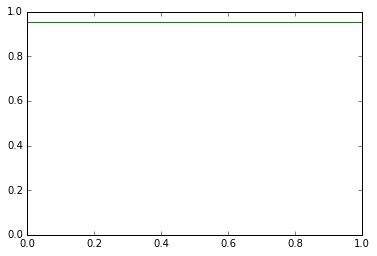

In [13]:
print(curLosses['validation'])


plt.figure(0)
i += 1
plt.plot(curLosses['train'], label="kos")
plt.plot(curLosses['validation'], label="nos")
_ = plt.ylim()